# Project 3 : Web APIs & NLP - Classification of subreddit posts

## Part 4 - Modelling, Evaluation & Conclusion

## Import Libraries
### NOTE: SKLearn ver 1.0 is required for the .get_feature_names_out() method. Else, there will be runtime error.

In [1]:
# import libraries

import requests
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, plot_roc_curve, f1_score, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# set config to display all
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Modelling

### Define the y-variable.

In [3]:
clean_data = pd.read_csv('../data/clean_data.csv')

In [4]:
y = clean_data['is_investing']

In [5]:
y.shape

(9417,)

In [6]:
y.head(1)

0    1
Name: is_investing, dtype: int64

### Define the X-variables
Currently this is the 'cleaned' column of text prior to vectorization.

In [7]:
X = clean_data['joint']

In [8]:
X.shape

(9417,)

In [9]:
X.head(1)

0    great short setup nyse snapshothttpswwwtradingviewcomxxdfupjmd ampxb double top ath level bullish rsi divergence
Name: joint, dtype: object

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

In [11]:
X_train.shape

(7062,)

In [12]:
y_train.shape

(7062,)

### Baseline Model

In [13]:
y.value_counts(normalize=True)

0    0.518955
1    0.481045
Name: is_investing, dtype: float64

In the given dataset, 48.1% of the posts belongs to the subreddit of r/investing while 51.9% of the posts belongs to the subreddit of r/CryptoCurrency.  
The baseline model is thus set as higher probability of occurrences of r/CryptoCurrency subreddit in the dataset, with an accuracy of 51.9%

| Model     | Accuracy   |
|:---------:|:----------:|
|Baseline   |    51.9%   |

### Preparing pipeline for CountVectorizer / TF-IDFVectorizer + Naive Bayes / Logistic Regression models

In [14]:
cvec_nb_pipeline = Pipeline([('cvec', CountVectorizer()),
                            ('mb', MultinomialNB())])
tvec_nb_pipeline = Pipeline([('tvec', TfidfVectorizer()),
                            ('mb', MultinomialNB())])
cvec_lr_pipeline = Pipeline([('cvec', CountVectorizer()),
                            ('lr', LogisticRegression(solver='liblinear'))])
tvec_lr_pipeline = Pipeline([('tvec', TfidfVectorizer()),
                            ('lr', LogisticRegression(solver='liblinear'))])

### Defining hyperparameters for grid search

**Vectorizer max_features**  
The max_features for the Vectorizer are set up to 3000, i.e. 3000 columns/word(s). While a higher number of columns could be desirable to improve model accuracy, this increases the computing resource as well and increase the model complexity. We will take a deeper look at this hyperparameter later, to determine a possible sweet spot as incremental columns has diminishing returns.

**Vectorizer ngram_range**  
The ngram_range is set with the following, up to tetragrams.
- unigrams only
- unigrams to bigrams
- unigrams to trigrams
- unigrams to tetrgrams

**Vectorizer max_df**  \
The max_df pertains to the removal of words that has a document frequency beyond the specified number. For this to be useful, the number has to be above the higher of the document weights of either category. Intention for this is to remove the words that occurs in a high number of documents and across both categories.\
For this, a range of 80% and 90% shall be considered as anything too low could result in the removal of words that are dominant in a particular category.

**Vectorizer min_df**  \
The min_df pertains to the removal of words that has a document frequency is less than the specified number. In this case, the max_features will ensure the low frequency words would not be captured and hence, this was considered but not used as a defining hyperparameter.

**Logistic Regression C (inverse of regularization strength)**  
C is set between the range of 0.01 to 100, where a lower values specify stronger regularization. This is likely to be useful for CountVectorizer where the min-max range of count frequency could be wide.

**Logistic Regression penality**  
L1 and L2 penalty will be set for model to determine the appropriate penalty norm.

In [15]:
cvec_nb_params ={
    'cvec__max_features':[100, 500, 1000, 2000, 3000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'cvec__max_df':[0.8, 0.9]
}

In [16]:
tvec_nb_params ={
    'tvec__max_features':[100, 500, 1000, 2000, 3000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'tvec__max_df':[0.8, 0.9]
}

In [17]:
cvec_lr_params ={
    'cvec__max_features':[3000],
    'cvec__ngram_range': [(1,4)],
    'cvec__max_df':[0.8],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty':['l1', 'l2']
}

In [18]:
tvec_lr_params ={
    'tvec__max_features':[3000],
    'tvec__ngram_range': [(1,4)],
    'tvec__max_df':[0.8],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty':['l1', 'l2']
}

Based on the specified hyperparameters to tune, the logistic regression will have 10x more fitting to be dome. This takes more computational resources and more time to generate the best parameters.\
In order to speed things up, will assume that best Vectorizer parameters derived by the the Naive Bayes model holds true.\
Once again, this is KIV and we will take a look at the scores and determine if further optimization or tuning is necessary.

### Instantiate GridSearchCV

In [19]:
cvec_nb_gs = GridSearchCV(cvec_nb_pipeline, param_grid=cvec_nb_params, cv=5, verbose=1, n_jobs=-1)

In [20]:
tvec_nb_gs = GridSearchCV(tvec_nb_pipeline, param_grid=tvec_nb_params, cv=5, verbose=1, n_jobs=-1)

In [21]:
cvec_lr_gs = GridSearchCV(cvec_lr_pipeline, param_grid=cvec_lr_params, cv=5, verbose=1, n_jobs=-1)

In [22]:
tvec_lr_gs = GridSearchCV(tvec_lr_pipeline, param_grid=tvec_lr_params, cv=5, verbose=1, n_jobs=-1)

### Fitting the data into GridSearchCV to obtain model with best hyperparameters

In [23]:
cvec_nb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.9],
                         'cvec__max_features': [100, 500, 1000, 2000, 3000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]},
             verbose=1)

In [24]:
tvec_nb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.8, 0.9],
                         'tvec__max_features': [100, 500, 1000, 2000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]},
             verbose=1)

In [25]:
cvec_lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8], 'cvec__max_features': [3000],
                         'cvec__ngram_range': [(1, 4)],
                         'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2']},
             verbose=1)

In [26]:
tvec_lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2'], 'tvec__max_df': [0.8],
                         'tvec__max_features': [3000],
                         'tvec__ngram_range': [(1, 4)]},
             verbose=1)

### Preview the best hyperparameters obtained through GridSearchCV

In [27]:
print(cvec_nb_gs.best_params_)
print(tvec_nb_gs.best_params_)
print(cvec_lr_gs.best_params_)
print(tvec_lr_gs.best_params_)

{'cvec__max_df': 0.8, 'cvec__max_features': 2000, 'cvec__ngram_range': (1, 4)}
{'tvec__max_df': 0.8, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 4)}
{'cvec__max_df': 0.8, 'cvec__max_features': 3000, 'cvec__ngram_range': (1, 4), 'lr__C': 0.01, 'lr__penalty': 'l2'}
{'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.8, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 4)}


Notably, the optimal max_features is 3000, which is the max defined for GridSearchCV. Lets take a look at the each modelled scores before delving into this further, i.e. whether we should increase the max range further.  
Likewise for the C for CountVectorizer + Logistic Regression, which is at the minimum (0.01) of the range set for GridSearch. Lets take a deeper look at its score before further tuning.

### Classification scores
Lets define a function to break down the different classification scores.

In [28]:
# Note that this requires SKLearn version 1.0
def scores(model):
    
    # derive tn, fp, tn, tp from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    # derive vectorizer and model type
    try: 
        re.search(r'cvec' ,str(model)).group() == 'cvec'
        vect = 'CountVectorizer'
    except Exception:
        pass
    
    try:
        re.search(r'tvec' ,str(model)).group() == 'tvec'
        vect = 'TF-IDF Vectorizer'
    except Exception:
        pass
    
    try:
        re.search(r'mb' ,str(model)).group() == 'mb'
        mod = 'Naive Bayes Classifier'
    except Exception:
        pass
    
    try:
        re.search(r'lr' ,str(model)).group() == 'lr'
        mod = 'Logistic Regression' 
    except Exception:
        pass
    
    try:
        re.search(r'gb' ,str(model)).group() == 'gb'
        mod = 'Gradient Boosting' 
    except Exception:
        pass
    
    try:
        re.search(r'rf' ,str(model)).group() == 'rf'
        mod = 'Random Forest' 
    except Exception:
        pass
    
    try:
        re.search(r'svc' ,str(model)).group() == 'svc'
        mod = 'Support Vector Machine' 
    except Exception:
        pass
       
    try:
        re.search(r'knn' ,str(model)).group() == 'knn'
        mod = 'K-Nearest Neighbors' 
    except Exception:
        pass

    # print results
    
    print(f'Model : {vect} + {mod}')
    print(f'Best CV score : {model.best_score_*100:.1f}%')
    print(f'Train score : {model.score(X_train, y_train)*100:.1f}%')
    print(f'Test score (accuracy) : {model.score(X_test, y_test)*100:.1f}%')
    print(f'Sensitivity (true positive rate) : {tp/(tp+fn)*100:.1f}%')
    print(f'Specificity (true negative rate) : {tn/(tn+fp)*100:.1f}%')
    print(f'Precision (positive predictive rate) : {tp/(tp+fp)*100:.1f}%')
    print(f'F1-score : {2*tp/(2*tp+fp+fn)*100:.1f}%')
    
    # plot confusion matrix
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(1, figsize=(12,8))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, 
                                          cmap = 'Greens', display_labels=('r/crytocurrency', 'r/investing'),
                                         ax=ax)
    ax.xaxis.labelpad=20
    

Model : CountVectorizer + Naive Bayes Classifier
Best CV score : 92.2%
Train score : 92.7%
Test score (accuracy) : 92.2%
Sensitivity (true positive rate) : 88.5%
Specificity (true negative rate) : 95.4%
Precision (positive predictive rate) : 94.4%
F1-score : 91.3%


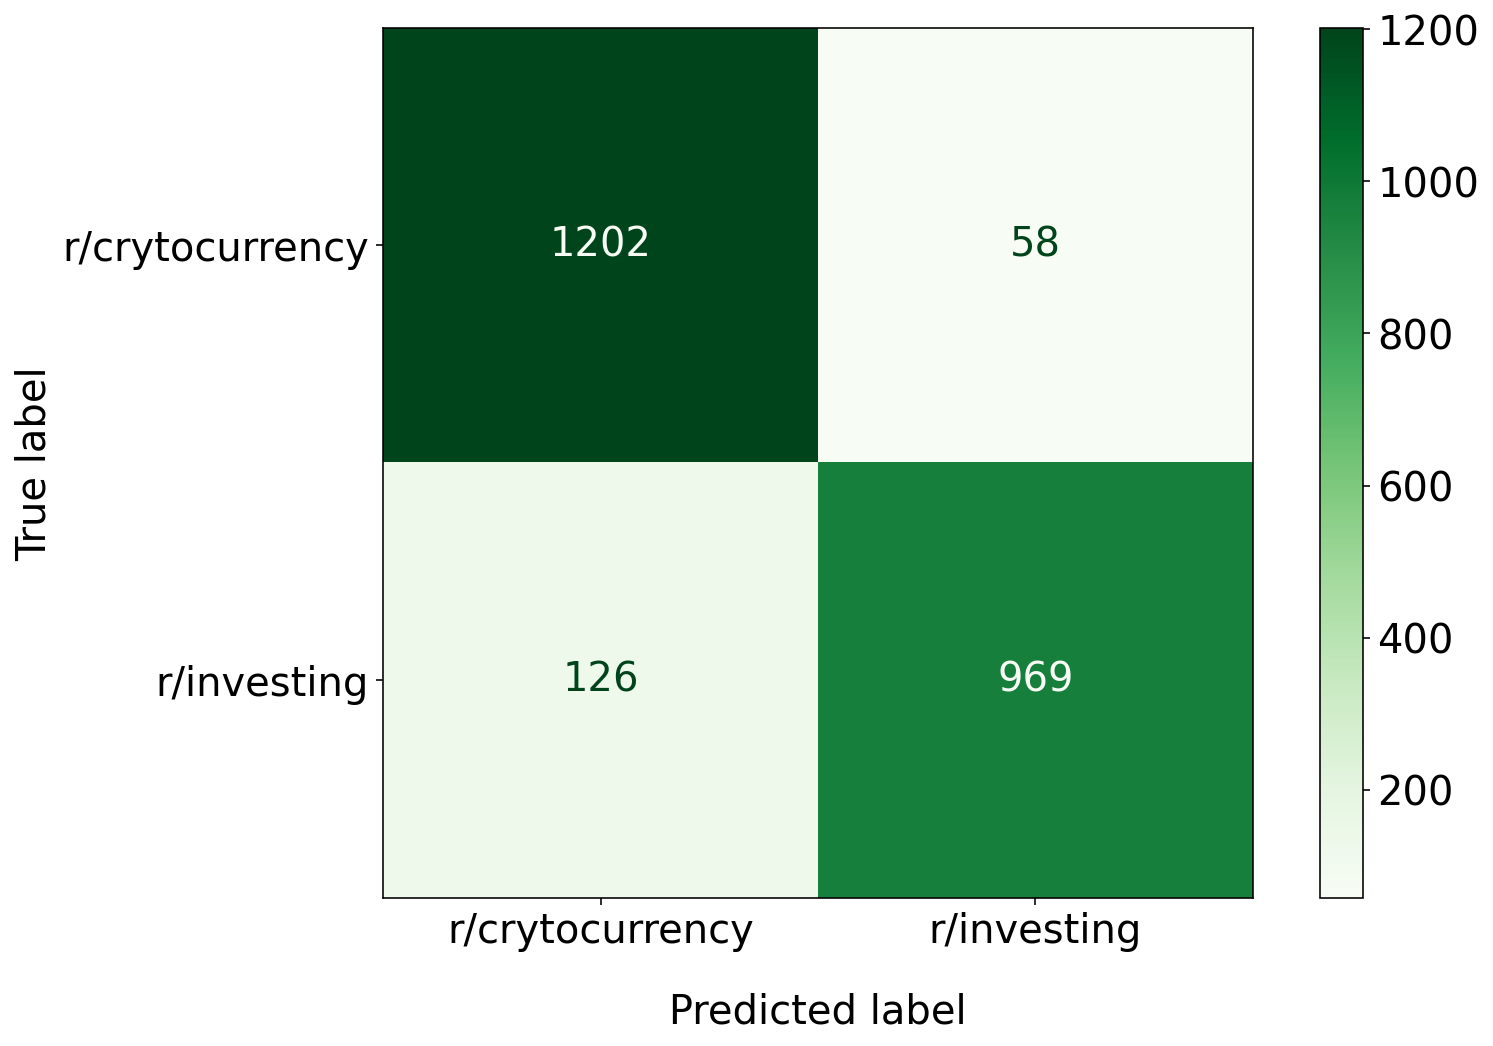

In [29]:
scores(cvec_nb_gs)

Model : TF-IDF Vectorizer + Naive Bayes Classifier
Best CV score : 92.3%
Train score : 93.3%
Test score (accuracy) : 92.6%
Sensitivity (true positive rate) : 90.0%
Specificity (true negative rate) : 94.9%
Precision (positive predictive rate) : 93.9%
F1-score : 91.9%


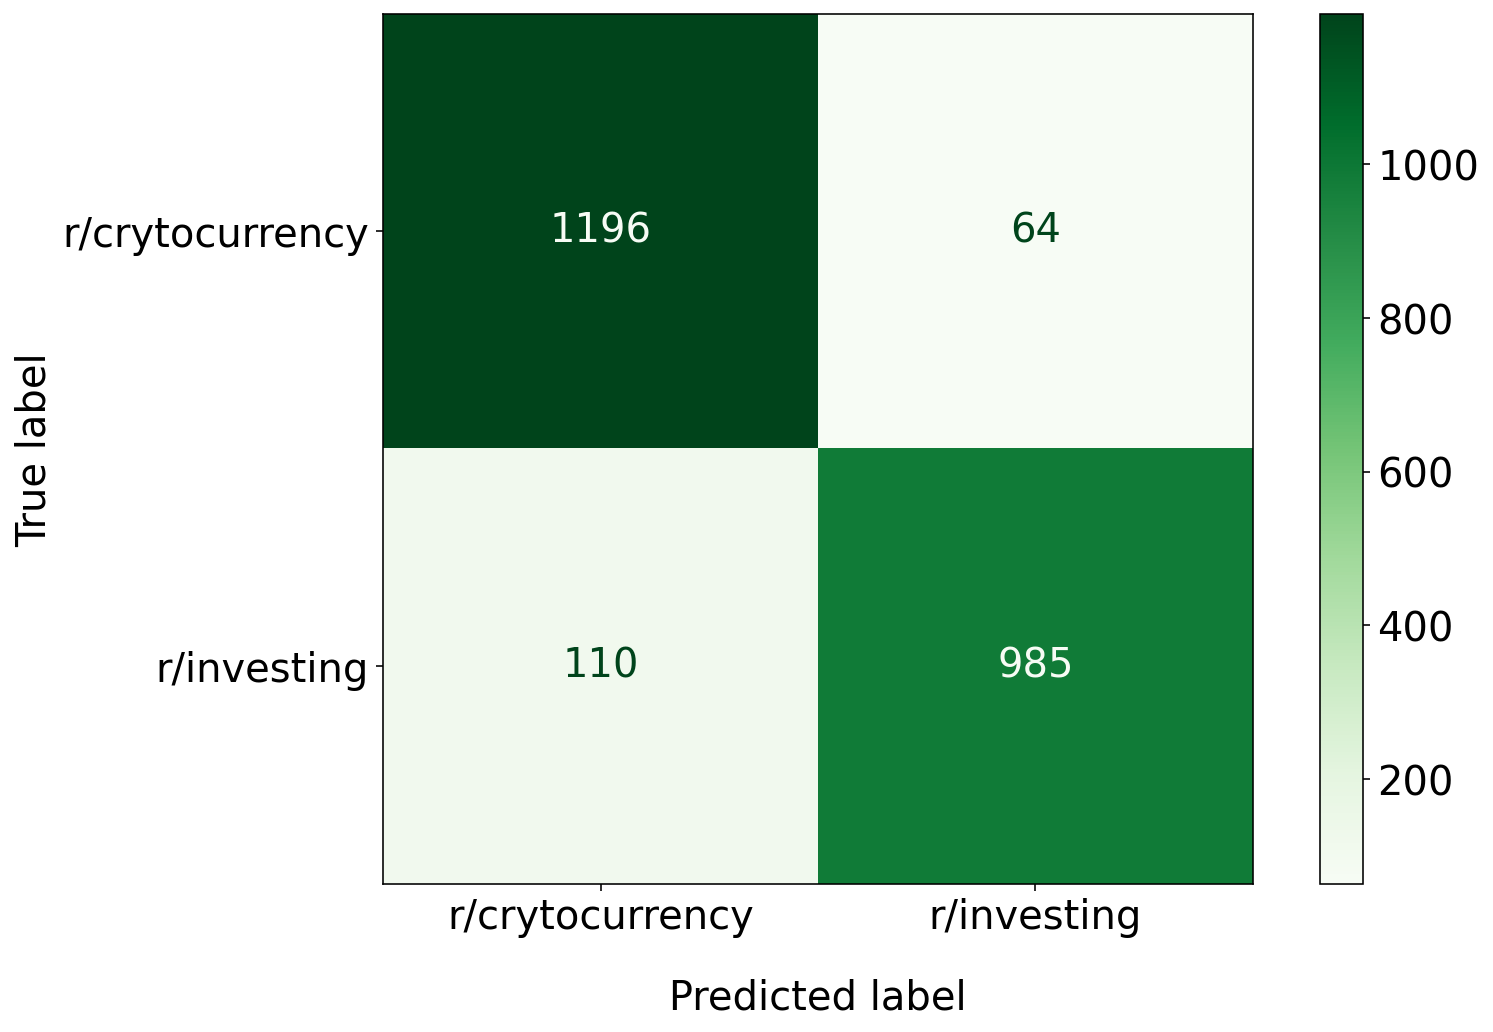

In [30]:
scores(tvec_nb_gs)

Model : CountVectorizer + Logistic Regression
Best CV score : 93.6%
Train score : 95.3%
Test score (accuracy) : 94.2%
Sensitivity (true positive rate) : 94.3%
Specificity (true negative rate) : 94.0%
Precision (positive predictive rate) : 93.2%
F1-score : 93.8%


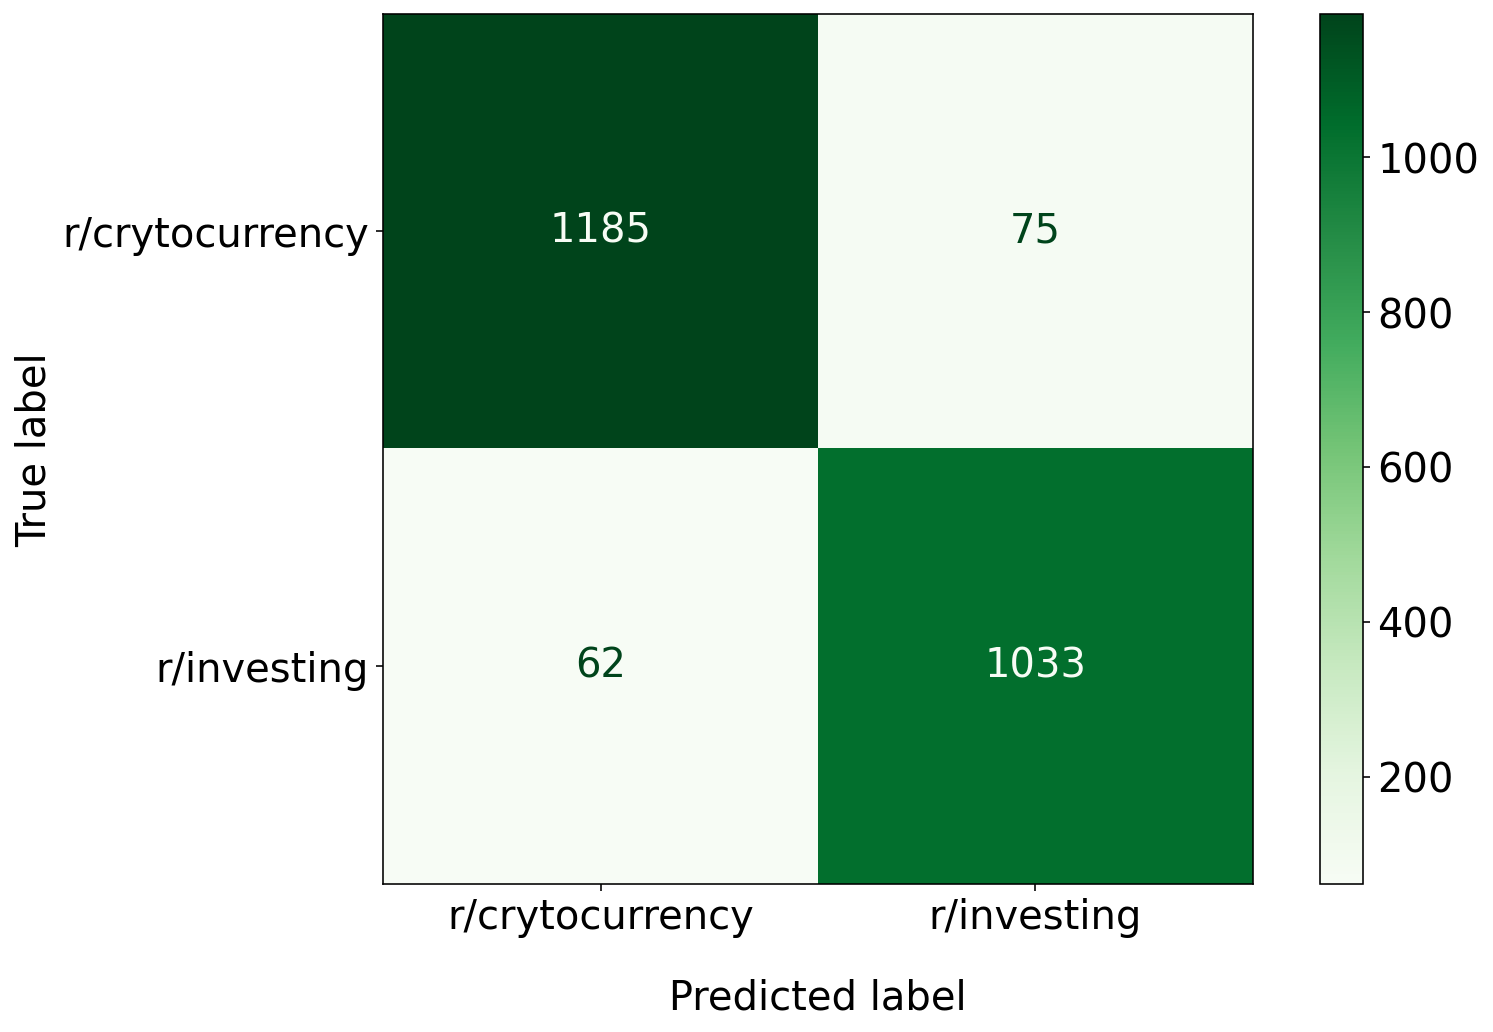

In [31]:
scores(cvec_lr_gs)

Model : TF-IDF Vectorizer + Logistic Regression
Best CV score : 94.1%
Train score : 95.9%
Test score (accuracy) : 94.9%
Sensitivity (true positive rate) : 94.2%
Specificity (true negative rate) : 95.5%
Precision (positive predictive rate) : 94.8%
F1-score : 94.5%


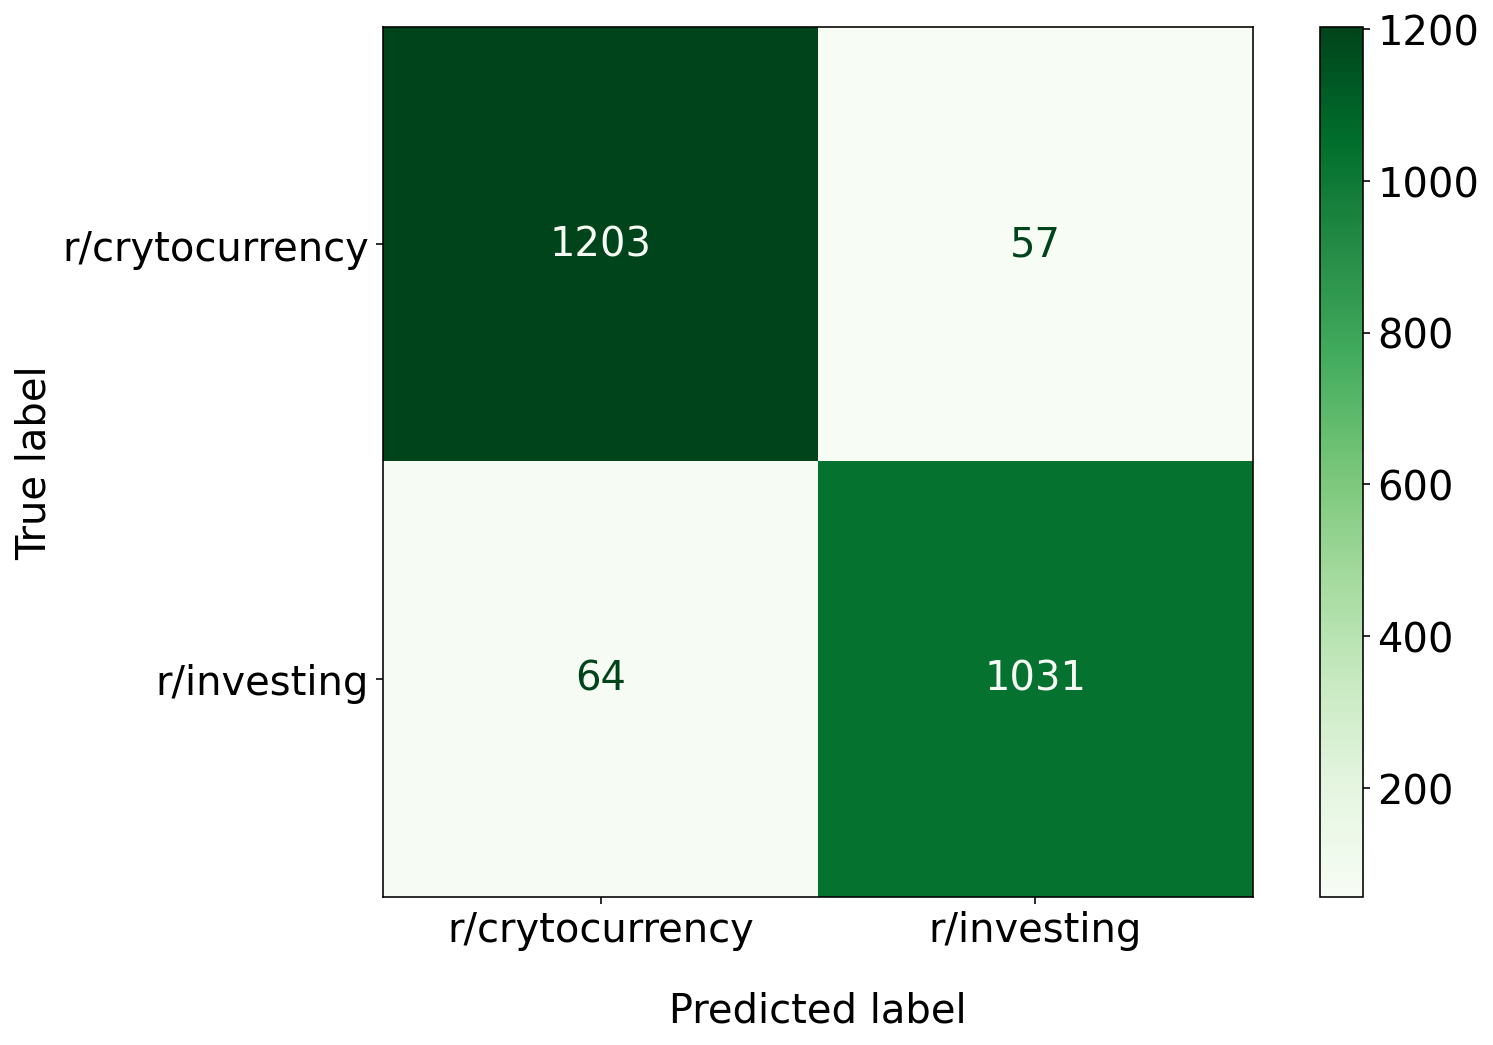

In [32]:
scores(tvec_lr_gs)

In general, TF-IDF Vectorizer seems to outperform the Count Vectorizer. This is hardly surprising, given that there is an additional element of 'normalization' by the TF-IDF Vectorizer to account for and reduce the weightage of high frequency and common words that appears in both subreddits.  
Logistic Regression also appears superior to the Naive Bayes Classifier from an accuracy standpoint. This could be related to how each algorithm classifies the problem. Naive Bayes is a generative model where there is an assumption on conditional independence for every feature. This is likely not the case as some words are likely to have contextual relationship with each other.\
There are also literature [(*source*)](https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c) suggesting that Logistic Regression tends to be superior when the dataset is large.\
We should also take a look at the other metrics to confirm that it is consistently true.  

| Model| Vectorizer| Best Cross Val| Train Accuracy| Test Accuracy| Sensitivity| Specificity| Precision| F1-Score|
|:-----|:---------:|:-------------:|:-------------:|:------------:|:----------:|:----------:|:--------:|:-------:|
|Naive Bayes Classifier| CVEC | 92.2% |      92.7% |        92.2% |      88.5% |      95.4% |     94.4%|    91.3%|
|Naive Bayes Classifier| TVEC | 92.3% |      93.3% |        92.6% |      90.0% |      94.9% |     93.9%|    91.9%|
|Logistic Regression   | CVEC | 93.6% |      95.3% |        94.2% |      94.3% |      94.0% |     93.2%|    93.8%|
|**Logistic Regression**   | **TVEC** | 94.1% |    95.9% |     94.9% |      94.2% |      95.5% |     94.8%|    94.5%|


Based on the above results, Logistic Regression + TF-IDF Vectorizer is the best model with highest scores for all the classification metrics with the exception of Sensitivity where it is ranked 2nd by 0.1%.\
This model has a test accuracy close to 95%, which means that 95% of the data are correctly classified as r/investing or r/cryptocurrency.\
It also was able to achieve a sensitivity rate of 94%, which means that the model is able to correctly identify 94% of all the posts that are r/investing.\
Likewise, the model has a specificity rate of 96%, which means it is able to correctly identify 96% of all the posts that are r/cryptocurrency.\
This will be the chosen model.

### Hyperparameters revisit
As discussed earlier, lets revisit the hyperparameters for max_features and ngram_range for the chosen model, given that there was an assumption made on these hyperparameters to reduce the runtime.

Recall the best parameters for TVEC + Logistic Regression

In [33]:
print(tvec_lr_gs.best_params_)

{'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.8, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 4)}


Define function to plot the hyperparameters

In [34]:
def plot_hyper(max_f=3000, ngram_r=(1,4), maxdf=0.8):
    
    # set up the pipeline for modelling
    model = Pipeline([('tvec', TfidfVectorizer(max_features=max_f, ngram_range=ngram_r, max_df=maxdf)),
                      ('lr', LogisticRegression(solver='liblinear', C=1, penalty='l2'))])
    
    # using CV=2 to save time since we are interested in only the test scores
#     model = GridSearchCV(tvec_lr_pipe, param_grid=params, cv=2, verbose=1, n_jobs=-1)
    
    # fit the model and derive the test score
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return score

### Plot the max features

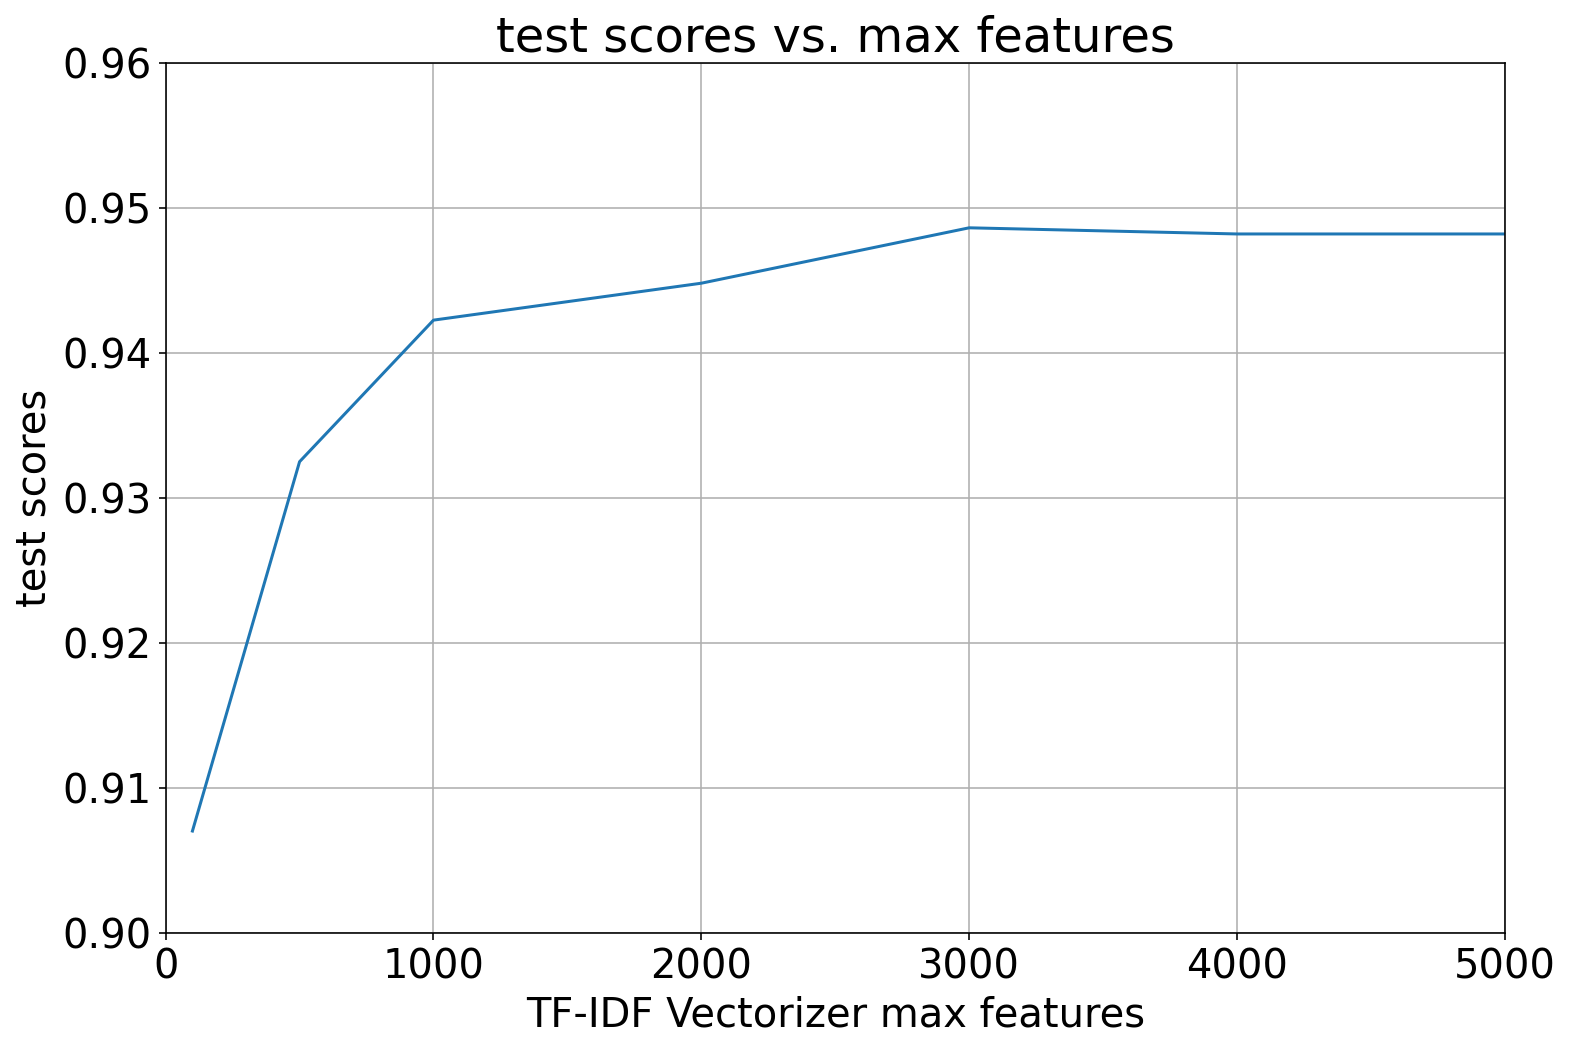

In [35]:
# generate a placeholder list to contain the respective scores from each parameter
mf_list = []

# define the range of parameters to establish the test scores
max_feat = [100, 500, 1000, 2000, 3000, 4000, 5000]

# fit the model for each parameter of interest to establish the test scores
for i in max_feat:   
    mf_list.append(plot_hyper(max_f=i))

# plot the curve
plt.figure(figsize=(12,8))
plt.plot(max_feat, mf_list)
plt.grid()
plt.ylim(0.9,0.96)
plt.xlim(0,5000)
plt.title('test scores vs. max features')
plt.xlabel('TF-IDF Vectorizer max features')
plt.ylabel('test scores')
plt.show()

Indeed there is diminishing returns for increasing the max features. In this case, keeping the max features at 3000 is satisfactory. In fact, it could be worthwhile to consider reducing the complexity by selecting 1000 or 2000 max features at an expense of <0.01 score!\
For the purpose of this project, we will keep it at 3000 max features having satisfied that there is minimal returns on increasing it.

### Plot the ngram_range

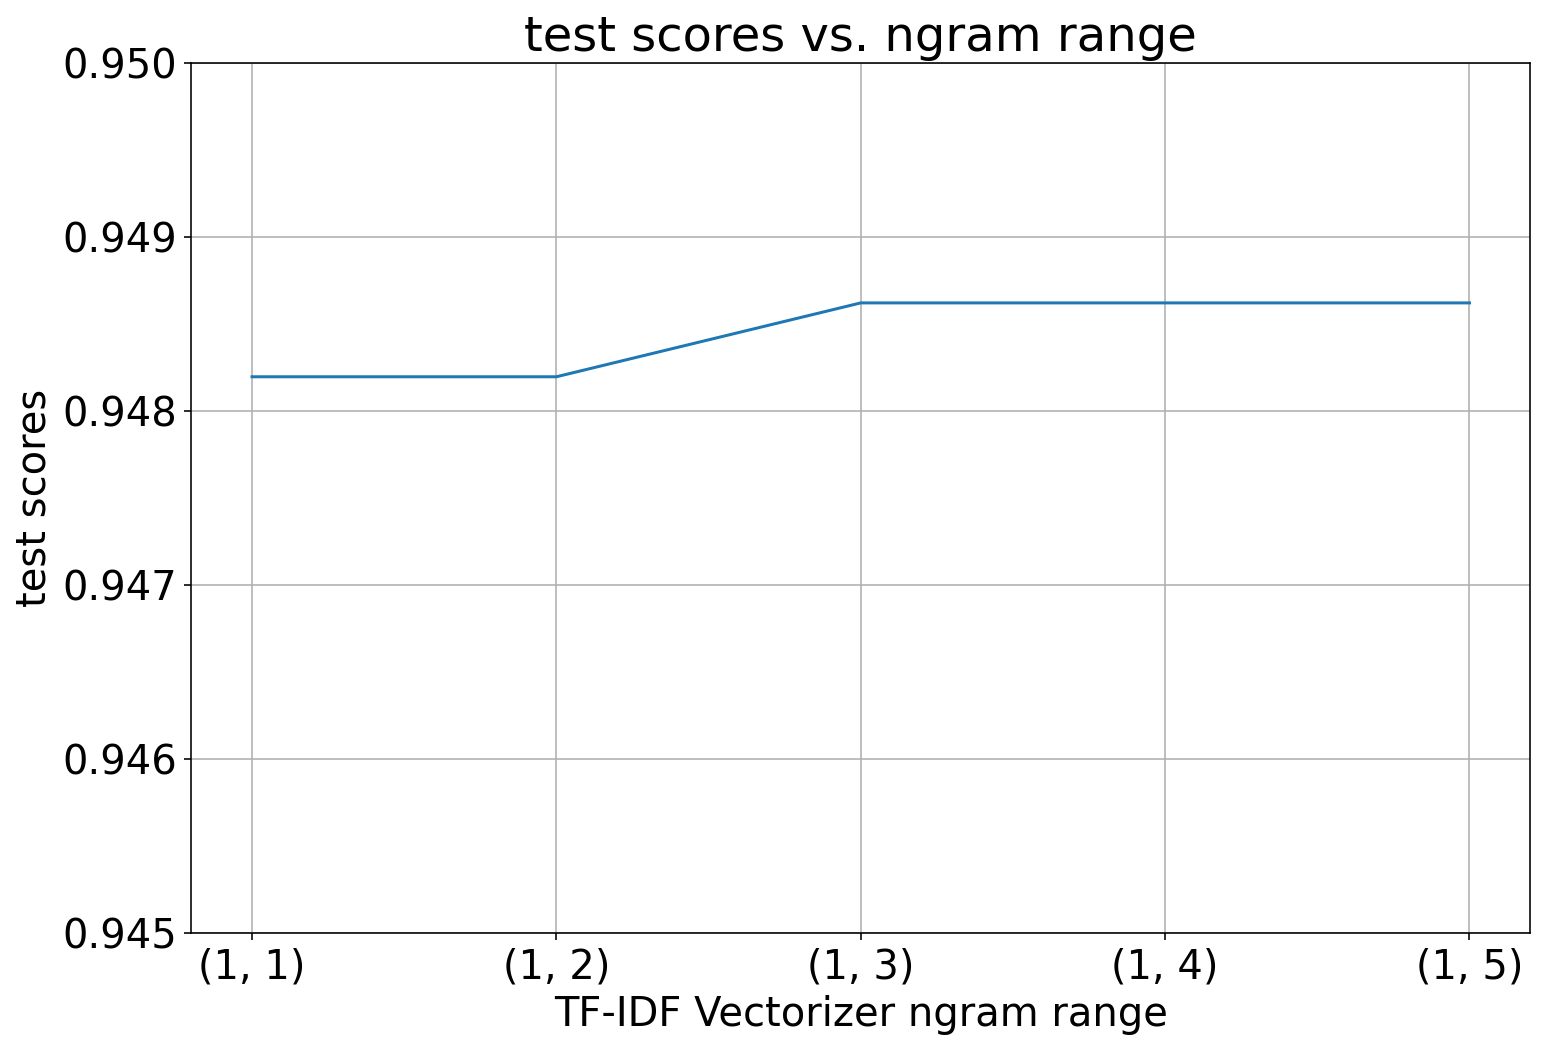

In [36]:
# generate a placeholder list to contain the respective scores from each parameter
ng_list = []

# define the range of parameters to establish the test scores
ngram = [(1,1), (1,2), (1,3), (1,4), (1,5)]

# generate a placeholder list given to be parsed into a string since the parameter is not an int/float
x_list = []

# fit the model for each parameter of interest to establish the test scores
for i in ngram:
    ng_list.append(plot_hyper(ngram_r=i))
    x_list.append(str(i))

# plot the curve
plt.figure(figsize=(12,8))
plt.plot(x_list, ng_list)
plt.grid()
plt.ylim(0.945,0.95)
plt.title('test scores vs. ngram range')
plt.xlabel('TF-IDF Vectorizer ngram range')
plt.ylabel('test scores')
plt.show()

The difference in scores across the range of ngrams is negligible.\
The assumption made to reduce runtime, that ngram_range (1,4) is optimal for this model can be allowed to stand.

### Plot the max_df

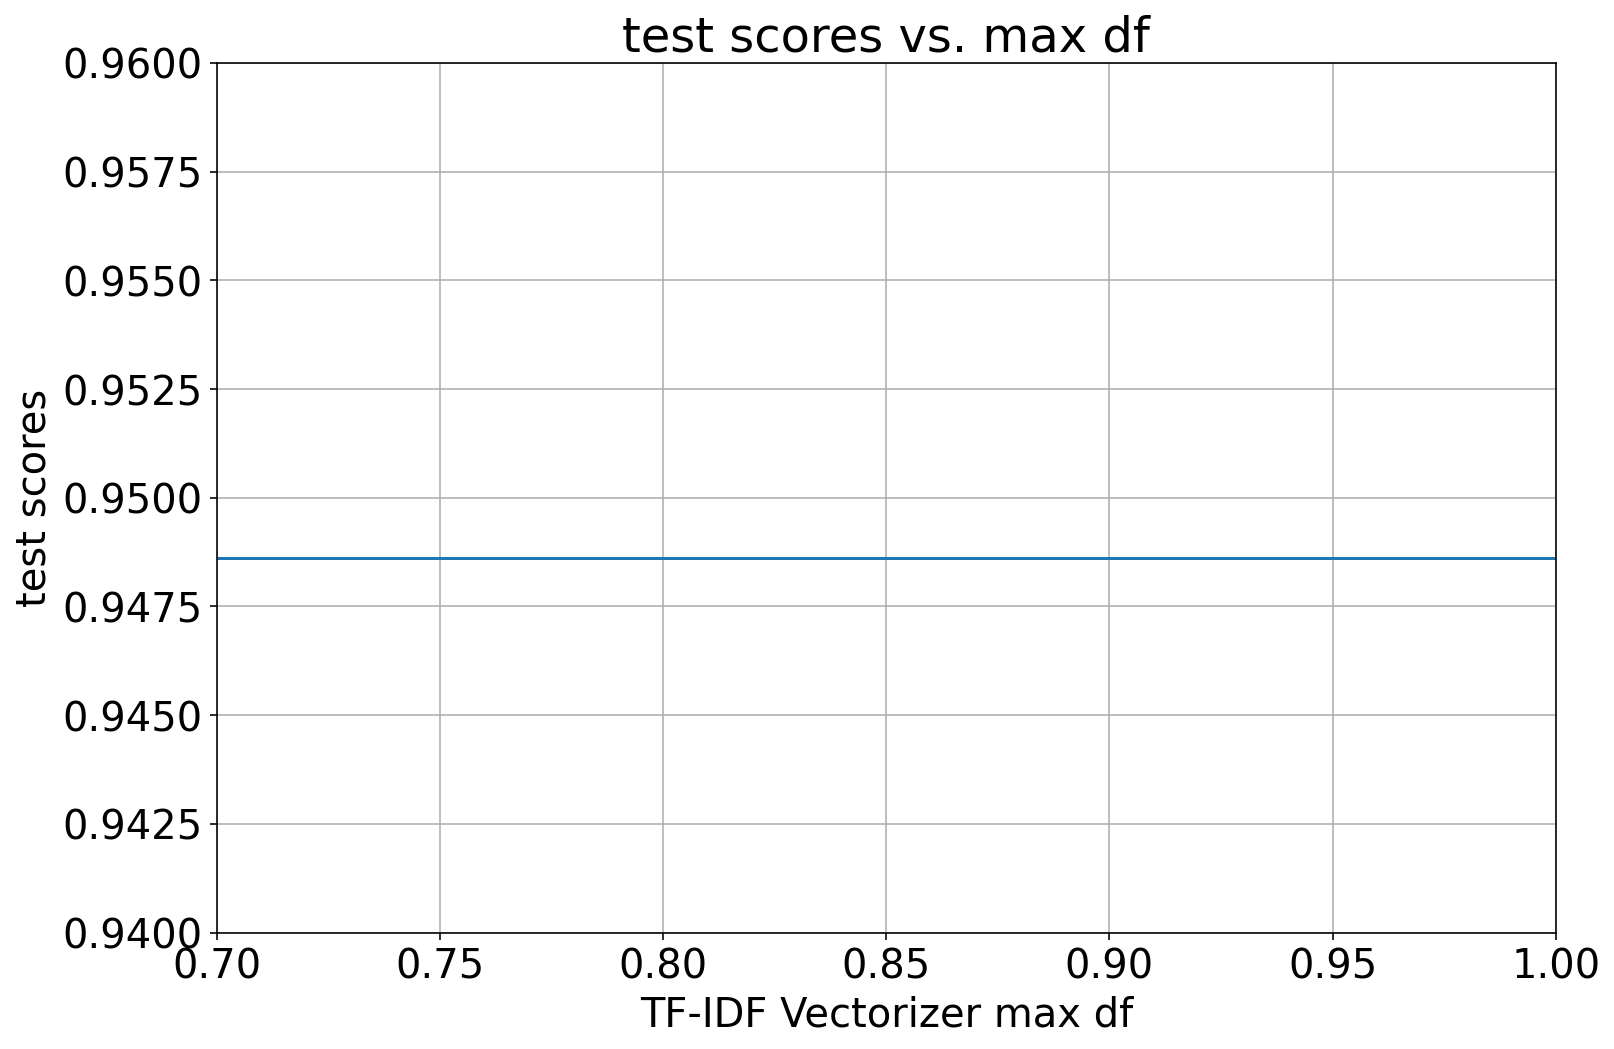

In [37]:
# generate a placeholder list to contain the respective scores from each parameter
df_list = []

# define the range of parameters to establish the test scores
max_df_list = [0.7, 0.8, 0.9, 1.0]

# fit the model for each parameter of interest to establish the test scores
for i in max_df_list:   
    df_list.append(plot_hyper(maxdf=i))

# plot the curve
plt.figure(figsize=(12,8))
plt.plot(max_df_list, df_list)
plt.grid()
plt.ylim(0.94,0.96)
plt.xlim(0.7,1)
plt.title('test scores vs. max df')
plt.xlabel('TF-IDF Vectorizer max df')
plt.ylabel('test scores')
plt.show()

It appears that there are no word with document frequency in excess of 70%, such that there is no change in the scores. With this, this hyperparameter can be omitted.

### Model scrutiny

Establish the final model.

In [38]:
# set up the pipeline for the chosen model
model = Pipeline([
    ('tvec', TfidfVectorizer(max_features=3000, ngram_range=(1,4))),
    ('lr', LogisticRegression(solver='liblinear', C=1, penalty='l2'))
])

# fit the model
model.fit(X_train, y_train)

# transform the X_test with the vectorizer
tr_X_test = model['tvec'].transform(X_test)

Plot the ROC curve.

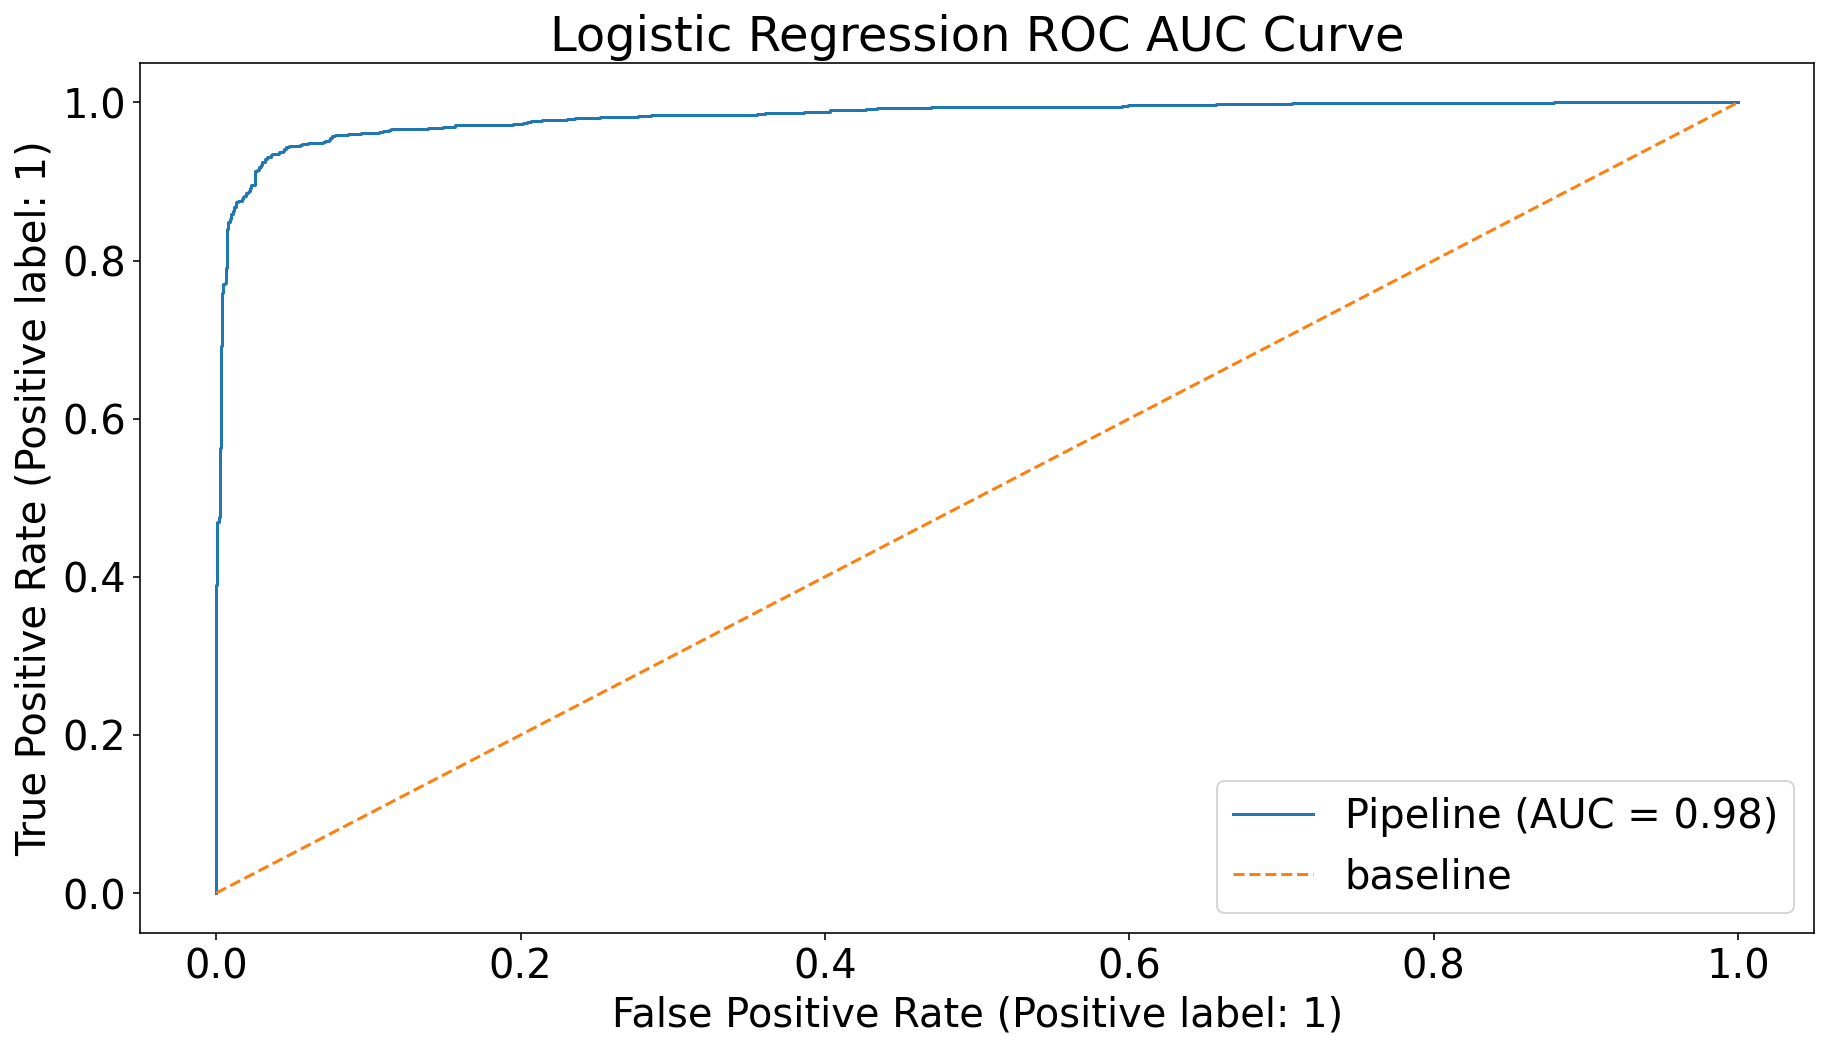

In [39]:
fig, ax = plt.subplots(figsize=(15,8))
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
plt.plot([0,1], [0,1], label='baseline', linestyle='--')
plt.legend()
plt.title('Logistic Regression ROC AUC Curve')
plt.show()

The ROC AUC score of 0.98 out of 1.00 is respectable. In general, the higher the ROC AUC score, the better the model is at distinguishing between r/investing and r/cryptocurrency posts.

Derive the coefficients for the Logistic Regression model and confirm there are 3000 coefficients

In [40]:
model['lr'].intercept_

array([0.24515353])

In [41]:
print(model['lr'].coef_)
model['lr'].coef_.shape

[[0.67397388 0.06063133 0.09266735 ... 0.45157529 0.48419674 0.09716925]]


(1, 3000)

Given that it is a 2D array, flatten to a 1D array.

In [42]:
flat_coef = np.ravel(model['lr'].coef_)
flat_coef.shape

(3000,)

Get the columns of features from the Vectorizer and confirm there are 3000 features.

In [43]:
features = model['tvec'].get_feature_names_out()
features.shape

(3000,)

Organizing the features and its Logistic Regression coefficients into dataframe.

In [44]:
model_coef = pd.DataFrame(zip(features,flat_coef), columns = ['feature', 'coef'])
model_coef.head()

,feature,coef
0,aapl,0.673974
1,ability,0.060631
2,able,0.092667
3,absolute,-0.006712
4,absolutely,0.034388


Obtain the top 10 features that has positive coefficients, i.e. associated with r/investing.

In [45]:
invest_coef = model_coef.sort_values(by='coef', ascending=False)
invest_coef.head(10)

,feature,coef
2533,stock,7.517758
528,company,5.350883
2377,share,3.949055
1412,investing,3.569332
1862,option,2.395485
1414,investment,2.290506
1130,fund,2.247842
1416,investor,2.086000
1627,market,2.060704
2286,roth,2.005548


Obtain the top 10 features that has negative coefficients, i.e. associated with r/cryptocurrency.

In [46]:
crypto_coef = model_coef.sort_values(by='coef', ascending=True)
crypto_coef.head(10)

,feature,coef
640,crypto,-9.107364
502,coin,-5.933210
342,btc,-4.769485
278,bitcoin,-4.268413
2866,wallet,-3.691927
1722,moon,-3.344757
907,eth,-3.169479
276,binance,-3.047496
2078,project,-2.955654
653,cryptocurrency,-2.767000


Interpret the coefficients which are log(odds) to odds and subsequently to probabilty.

In [47]:
# coefficients are the log(odds), to get the odds, apply exponential function
invest_coef['odds'] = np.exp(invest_coef['coef'])
crypto_coef['odds'] = np.exp(crypto_coef['coef'])

# to get the probability from the odds, apply odds/(1+odds)
invest_coef['prob'] = invest_coef['odds']/(1+invest_coef['odds'])*100

# note that the coefficients and probability p are based on investing
# therefore the coefficients from cryptocurrency basis is 1-p
crypto_coef['1-prob'] = crypto_coef['odds']/(1+crypto_coef['odds'])*100
crypto_coef['prob'] = 100-crypto_coef['1-prob']

In [48]:
invest_coef.head(10)

,feature,coef,odds,prob
2533,stock,7.517758,1840.437224,99.945695
528,company,5.350883,210.794414,99.527844
2377,share,3.949055,51.886303,98.109151
1412,investing,3.569332,35.492882,97.259740
1862,option,2.395485,10.973519,91.648236
1414,investment,2.290506,9.879933,90.808767
1130,fund,2.247842,9.467283,90.446422
1416,investor,2.086000,8.052642,88.953501
1627,market,2.060704,7.851495,88.702473
2286,roth,2.005548,7.430162,88.137832


In [49]:
crypto_coef.head()

,feature,coef,odds,1-prob,prob
640,crypto,-9.107364,0.000111,0.011083,99.988917
502,coin,-5.933210,0.002650,0.264296,99.735704
342,btc,-4.769485,0.008485,0.841336,99.158664
278,bitcoin,-4.268413,0.014004,1.381058,98.618942
2866,wallet,-3.691927,0.024924,2.431783,97.568217


### Feature importance summary

Below shows the top 10 key words that are associated with the respective subreddits, in descending order of predictive strength.\
As an illustration, the word 'stock' has an odds of 1839-1 of being in r/investing than in r/CryptoCurrency. In other words, the word 'stock' has 99.95% probability to be observed in r/investing than in r/CryptoCurrency.\
At the same time, the word 'crypto' an odds of over 9000-1 or a probability of 99.99% to be observed in r/CrytoCurrency than in r/investing.


|r/investing Featured Words|Log(Odds)|Odds|Probability|
|:------------------------:|:-------:|:--:|:---------:|
|	stock	|	7.52	|	1839.26	|	99.95%	|
|	company	|	5.35	|	210.59	|	99.53%	|
|	share	|	3.95	|	51.84	|	98.11%	|
|	investing	|	3.57	|	35.46	|	97.26%	|
|	option	|	2.39	|	10.96	|	91.64%	|
|	investment	|	2.29	|	9.87	|	90.80%	|
|	fund	|	2.25	|	9.46	|	90.44%	|
|	investor	|	2.08	|	8.04	|	88.94%	|
|	market	|	2.06	|	7.84	|	88.69%	|
|	roth	|	2.01	|	7.43	|	88.13%	|

|r/CryptoCurrency Featured Words|Log(Odds)|Odds|Probability|
|:------------------------:|:-------:|:--:|:---------:|
|	crypto	|	9.11	|	9039.02	|	99.99%	|
|	coin	|	5.94	|	378.48	|	99.74%	|
|	btc	|	4.77	|	117.95	|	99.16%	|
|	bitcoin	|	4.27	|	71.52	|	98.62%	|
|	wallet	|	3.69	|	40.18	|	97.57%	|
|	moon	|	3.35	|	28.39	|	96.60%	|
|	eth	|	3.17	|	23.82	|	95.97%	|
|	binance	|	3.05	|	21.07	|	95.47%	|
|	project	|	2.96	|	19.23	|	95.06%	|
|	cryptocurrency	|	2.77	|	15.92	|	94.09%	|

### Misclassification Analysis

Construct a dataframe of test data, actual and predicted y-variable.

In [50]:
preds = model.predict(X_test)
preds.shape

(2355,)

In [51]:
y_test.shape

(2355,)

In [52]:
X_test.shape

(2355,)

In [53]:
test_df = pd.DataFrame(zip(X_test, y_test, preds), columns = ['text', 'actual', 'predicted'])

In [54]:
test_df.head()

,text,actual,predicted
0,divisibility cryptocurrency token divisibility break divisibility familiar dollar cent many currency use system usdaudetc one dollar one hundred cent really le one cent bank account dollar therefore divisible cent divide dollar one hundred cent cannot divide cent precision currency divided measured many decimal place support case dollar decimal place precision hereby known decimal cryptocurrencies revolutionising banking system exploring new frontier divisibility bitcoin example decimal place ie possible send receive little btc usd today price k usdbtc every person earth smallest unit bitcoin require btc price btc ever reach b btc thank hyperinflation smallest unit cost usd suddenly smallest unit may enough ethereum take next level course supporting decimal place precision quite hard fathom another way put say every person earth billion smallest unit ethereum require eth chemistry nut precision individual atom mg carbon p wrong number read comment whenever someone wrong internet so...,0,0
1,want crypto cost low transaction fee send others proton wallet sending xpr proton coin user free transaction fee none personally lot people send money family member country pay ridiculous amount money send either every week every month imagine sending get exactly love crypto there need crypto answer proton answered made fee transfer walet saying proton great buy investment want send crypto people pay fee definetly one use want inovations crypto getting love shill dont buy really dont care lol showing feeless crypto exist,0,0
2,ship sailed already hello fella brazilian started crypto journey month ago dont really well maybe one ive u crypto brl shitty largest shit need buy dollar dot ada ray tron audio algo nothing btc little bit eth considering almost ath bad moment buy btc eth ive seeing lot ppl saying go dramatically though dont give much attention cause biased opinion confess getting bit fomo last week,0,0
3,send usdt usd american bank account hi america want send usdt usd someone american bank account debit card fiat wallet best way le fee assuming person american crypto exchange crypto wallet really appreciate got advice suggestion thanks fill word post adding word looking forward advice wonderful day guy hope portfolio turn green today,0,0
4,buy stock beginner brokerage account etc want head start generation clue buy stock really want learn also stock suggestion free add pricy still able buy rich poor willing spend cad usd start suggestion free tell need certain app something also iphoneipad relevant thanks advance also best borokerage apps new set buy sell etc really nothing buy stock sell use friendly language thanks advance,1,1


Setting up the misclassification columns, where -1 is false positive and 1 is false negative

In [55]:
test_df['misclass'] = test_df['actual'] - test_df['predicted']

In [56]:
false_neg_text = test_df[test_df['misclass']==1]
false_pos_text = test_df[test_df['misclass']==-1]

Take a look at some of the misclassified posts.
#### Example 1: false negative
Confirms the count of false negative at 64

In [57]:
print(len(false_neg_text))
false_neg_text.head()

64


,text,actual,predicted,misclass
38,best friend asked guide invest crypto sure goodbad end recently got crypto month got good base term knowledge investing crypto particularly lower cap altcoins one time brought investing crypto two good friend month later one saying didnt want help succeed guiding sharing knowledge investing crypto eventually caved gonna guide start investing crypto knowledge term investing prior thus gonna investing larger market capped coin btc friend said wanted coin quote quote secure read lot money friend dont mix well together worried wont end good one day fall blame might even complain arent earning much road start getting greedy dont want come begging advice constantly certain gonna happen also keep asking much made much put crypto really bother dont want disclose earnings dont want think sort crypto god whatever average kid passionate investing crypto worked hard get knowledge dont want take advantage situation really want happen future make good money future altcoins gonna didnt tell keepi...,1,0,1
47,need advice possible good daynight everyone wasting lot money student wasting monthly almost usd last yr least since came college tho studying properly used say excuse fun lately watching lot video searching lot investment could give small advice whether something without getting scam really appreciate thank keep working hard,1,0,1
183,many people fell watermineioponzi tower finally collapsing week ago mom told crypto mining site guarantee daily return original investment catch tried explain company guarantee stable daily return fluctuating currency crypto course went one ear invested money anyways fast forward one week later waterminehttpswatermineio claiming hacked allowing user withdraw shocker still allow give money lol even took notice hacked front page site get little bit money drop good,1,0,1
211,lifetime deal take hope right subreddit family member offer garage buy k garage located middle block house streetside middle garage usually belong owner house opportunity buy one garage uncle uncle dad one got dad died uncle want get rid asap doesnt want deal stuff come buy price k garage sell k right located neighborhood there always someone want rent dad never trouble finding someone rent price maybe soon ask garage month sound good deal think still bit unsure there one old guy life owns lot garage he kind troublemaker couldnt buy garage family owns dad bit trouble tried blocking garage door etc simple bullying ask difficult deal legally however one right come rule etc cant u much harm question good deal getting really appreciate opinion deal good think,1,0,1
217,k ready portfolio development debtfree ive almost got k saved highyield saving account dont sitting collecting month wanted ask guy advice couple thing main question fundrise thing btw fidelity account ready go invest today yes much fundrise worth got email via mint thanks much hope everyone safe loved one well,1,0,1


The 1st and 3rd posts actually talks about cryptocurrency, bitcoin despite that it resides in the r/investing. In fact, I actually went to look at the raw .csv to confirm that this post resided in the r/investing subreddit as my initial reaction is that this could well be a post in the r/cryptocurrency subreddit.\
I can very well imagine that if human judgement is inadequate to judge that this post was from the r/investing, there is no way we could fault the machine for misclassifying it.\
Unfortunately, it is a reality of life that posts like this is difficult to classify as it would not be out of place had it been posted in the r/cryptocurrency subreddit.

For the 2nd and 5th posts, they seem to be more generic with the exception that there are recurring 'invest' or 'investment' words. This could be where the model is unable to contextualize and it is likely there there are not many distinctive words to classify these correctly since the length of text is also relatively small.

For the 4th post, this appears more generic with no particular context that relates itself to investing. Such could be where the model is not able to adequately make a right classification due to lack of identifying feature words.

#### Example 2: false positive
Confirms the count of false positive at 57

In [58]:
print(len(false_pos_text))
false_pos_text.head()

57


,text,actual,predicted,misclass
27,today german government auction bitcoins darknet drug dealer worth million eur interesting case germany today ministry justice one germany state nrw auction bitcoins guy got caught selling drug internet government got access bitcoins wondered could legal counsel came conclusion treated item gained criminal activity hence auctioned sold public state keep money auction lead big hype germany auction usually lead discount whatever sold thought guy might find interesting article german background info httpswwwsueddeutschedewirtschaftbitcoinkryptowaehrungauktionnrwjustizministeriumamp need translation deeplcom provides best english ltgt german translation service,0,1,-1
71,myopic loss aversion panic sell sell early lock gain could gained far shown patience httpswwwbehavioraleconomicscomresourcesminiencyclopediaofbemyopiclossaversion myopic loss aversion occurs investor take view investment strongly focused short term leading react negatively recent loss may expense longterm benefit thaler et al phenomenon influenced narrow framing result investor considering specific investment eg individual stock trade without taking account bigger picture eg portfolio whole sequence trade time kahneman amp lovallo largescale field experiment shown individual receive information investment performance frequently tend underinvest riskier asset losing potential better longterm gain larson et al httpwwwbehavioraleconomicscommyopiclossaversionabehavioralanswertotheequitypremiumpuzzle experiment come partnering technology trading firm normann used beta test trading platform see access price information affected professional investor willingness take risk ultimate profit ...,0,1,-1
127,big usd inflow coming somewhere buy btc anyone evidence subject suggests recent runup doesnt retail buying probably explanation one guess money coming investment bank central bank hedge fund maybe anticipation strong news u regulatory environment time year always hard past ive seen company glassnode come public research showing money flow certain direction supporting strong hypothesis wondering anyone happens similar theory evidence back cheer,0,1,-1
135,year old learns daytrade crypto httpswwwyoutubecomwatchvlnifdfxvmyhttpswwwyoutubecomwatchvlnifdfxvmy hey guy name hasan yearold guy uk ive interested investingtrading around year investing crypto stock longterm roughly average return across portfolio last year however never properly ventured day tradingswing tradingscalping began get around year ago using macd rsi ema crap realised tbh doesnt really work ive revamped way traded based primarily price action identifying key level chart going ive decided create youtube series every week youll get see progression learning market work different book yt channel etc eventually applying understanding hopefully make profit short term trading begin lose well mean learning done ill take break trading real money go back paper practice refining error made past hope guy enjoy series ill post well keep updated,0,1,-1
171,u miner hosting market saturation lady gentleman u market saturation real electrical cost hosting rate pushing higher higher cent new cent mining high scale cent new five cent hosting cent new expensive pay still making money happy hosting thing get attacked people comment say compass offer interesting compass care upcharging electrical hosters get electrical cent charge rate make buy miner k markup make money per miner five year stretch cent markup example one pull watt hrsday kw x day x day month month profit hosting one cent markup x month year year x year projected life brand new compass get power cent charge cent view bit high right instead smart enough charge cent cent require buy miner k margin give money right away capital handoff expansion make think rate awesome although month wait get miner hosted month long response miner go one month profit electrical pay smaller facility cent year better going cent power hosting avoid long

For the 1st and 4th posts, it's unclear how the model decides on classifying it as r/investing instead of r/cryptocurrency subreddit as there are words like bitcoins and crypto that appeared in these texts. Perhaps the relative short word counts and lack of further defining words make it harder to the model to definitely classify it correctly.\

For the 3rd and 5th posts, there are few tell-tale words to suggest that these were posted in the r/cryptocurrency subreddit to a human as well. Apart from words like 'btc', 'mining' that were present once in the text, there is no strong indication to inform that these could come from the r/cryptocurrency subreddit.

For the 2nd post, it would not be out of place in the r/investing subreddit to a human. Such posts are indeed difficult to classify as they do not exhibit strong signs of describing about cryptocurrency.

### Misclassification summary

The model has performance respectably with regard to misclassification. Some of the misclassification would not be out of place in the 'misclassified' subreddit from a human judgement perspective based on the quality of text that were misclassified as false negative or false positive.\
As such, to do better than a 5% misclassification rate may require new features, perhaps comments to improve the prediction capability of the model, or the use of word vectors to provide the machine with some extent of contextual understanding.

## Conclusion

This is the final model selected with the following results:

| Model| Vectorizer| Best Cross Val| Train Accuracy| Test Accuracy| Sensitivity| Specificity| Precision| F1-Score|
|:-----|:---------:|:-------------:|:-------------:|:------------:|:----------:|:----------:|:--------:|:-------:|
|Logistic Regression   | TVEC | 94.1% |      95.9% |        94.9% |      94.2% |      95.5% |     94.8%|    94.5%|

Note: positive refers to r/investing subreddit while negative refers r/cryptocurrency subreddit.\
Therefore, sensitivity (true positive rate) refers to hit rate for predicting r/investing subreddit.\
In the same token, specificity (true negative rate) refers to the hit rate for predicting r/cryptocurrency subreddit.

This model has 95% accuracy, 94% sensitivity and 96% specificity.\
It is slightly able to predict a post in r/cryptocurrency (96%) better than a post in r/investing (94%). The slight betterment could be due to the consistently higher counts of oft-used lingo or words in the cryptocurrency space where the range of vocabulary is more specific. 
This is also reflected in the predictor words probabilty with 9 words having >95% likelihood to be belonging to the r/cryptocurrency as opposed to 4 words having >95% likelihood for r/investing subreddit.

The data cleaning is done at the basic level, with the removal of non-words and basic stopwords. Lemmatizer preferred over Stemming so as to preserve the integrity of dictionary words, given the focus on understanding and interpretability of the model. Likewise, a conscious decision has been made not to scale the data prior to model fitting, again in the spirit of interpretability or ease of model understanding. The use of hyperparameters such as max_df and max_features through Vectorizer acts as a pseudo-cleaning step. The use of min_df was also considered but ultimately not adopted as the removal of low frequency words is addressed by limiting the max_features hyperparameter. High word counts (if any) that occurs across both categories and thus has low predictive value will be disregarded through max_df hyperparameter. Distinct words such as misspelt or non-standard English vocabulary words will be naturally omitted as max_feature caps the highest occurring words to a limit.

Logistic Regression has been found superior to the Naive Bayes model, and across all key metrics of accuracy, specificity and sensitivity as illustrated above. Misclassification rate at 5% is not too much of a concern at the given time, based on the analysis of the misclassified text as those appeared to have some elements of ambiguity that even human judgement may not be able to accurately classify it in spite of the added element of contextual knowledge.

In conclusion, it can be said with 95% confidence that the developed model will be able to address the problem our trading firm has set out to achieve. Beyond being able to provide classification into r/investing or r/cryptocurrency subreddit, we were able to identify word predictors and its associated probability of making a correct classification. The understanding of this knowledge could then open further doors on classifying between investing or cryptocurrency on different platforms and fora. This could provide early detection for nascent topics before they go viral and have some impact on the equities or crytocurrency market.


## Recommendations

While this may be beyond the scope of the problem statement, based on the interesting insights from the misclassification, the current model could perhaps be extended as a tool to sort subreddit posts. In other words, an author who may have posted a cryptocurrency related discussion in the r/investing subreddit could be automatically be linked to the r/cryptocurrency subreddit such that his/her post could get higher engagement from like-minded contributors and authors.

Consideration can be made to expand the data collection beyond Reddit, to enable a larger vocabulary of words associated with the respective categories to be learned as there would be peculiar tendency for choice words in a specific forum like Reddit. This would expand the use of this model in a broader context.

As with all models, continued upkeep, validation and improvement should be carried out as choice words and word trends evolve over time, with perhaps new words being created.

## Appendix

### Testing with Gradient Boosting Classifier

In [63]:
# setting up the pipeline
tvec_gb_pipeline = Pipeline([('tvec', TfidfVectorizer(max_features=3000, ngram_range=(1,4))),
                            ('gb', GradientBoostingClassifier())])

In [64]:
# defining the parameters
gb_params = [
    {
        'gb__n_estimators': [300, 400],
        'gb__learning_rate': [0.1, 0.2, 0.3],
        'gb__max_depth': [4,5]
    }
]

In [65]:
# instantiate gridsearchcv
tvec_gb_gs = GridSearchCV(tvec_gb_pipeline, param_grid=gb_params, cv=5, verbose=1, n_jobs=-1)

In [66]:
# fit the model
tvec_gb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_features=3000,
                                                        ngram_range=(1, 4))),
                                       ('gb', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid=[{'gb__learning_rate': [0.1, 0.2, 0.3],
                          'gb__max_depth': [4, 5],
                          'gb__n_estimators': [300, 400]}],
             verbose=1)

In [67]:
# check out the best params
tvec_gb_gs.best_params_

{'gb__learning_rate': 0.2, 'gb__max_depth': 4, 'gb__n_estimators': 400}

Model : TF-IDF Vectorizer + Gradient Boosting
Best CV score : 93.4%
Train score : 100.0%
Test score (accuracy) : 93.8%
Sensitivity (true positive rate) : 93.9%
Specificity (true negative rate) : 93.8%
Precision (positive predictive rate) : 92.9%
F1-score : 93.4%


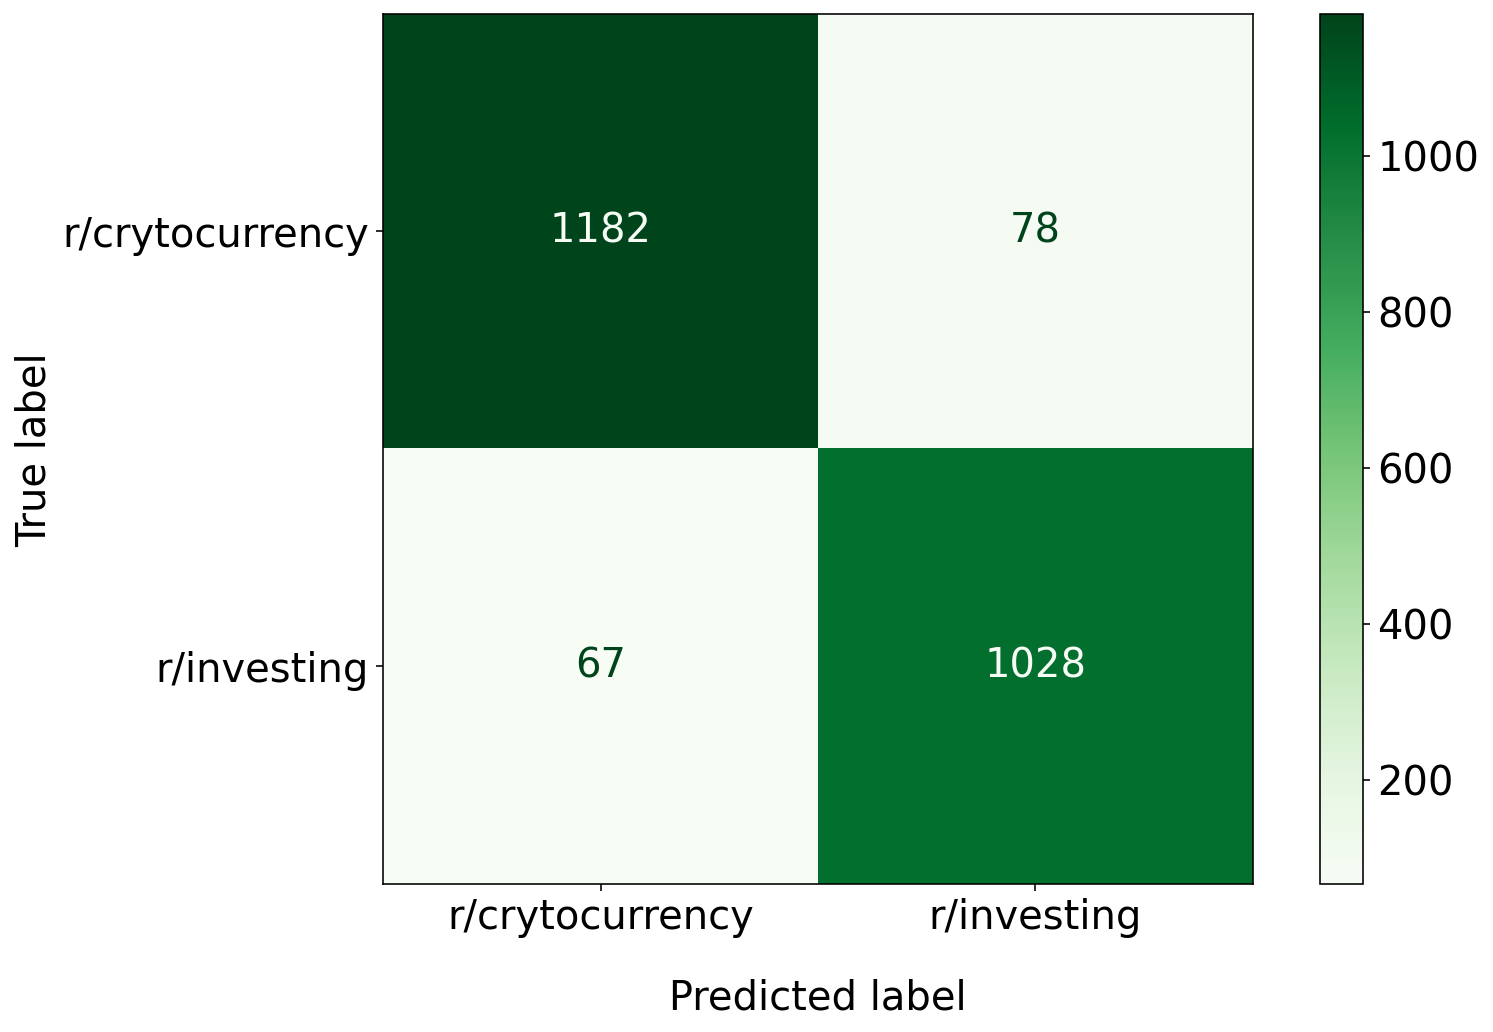

In [68]:
# check classification scores
scores(tvec_gb_gs)

The scores are not superior to the Logistic Regression from the perspective of accuracy, sensitivity and specificity... although given more time, further tuning may improve the model performance. What's worth noting is that the training score is 100%! This could be a sign of overfitting given the variance with the test scores.\
This could be the strength of Gradient Boost, given that the model learns from its mistake through the trees.\
Furthermore, Gradient Boosting Classifier is not a model with good interpretability.

### Testing with Random Forest Classifier

In [69]:
# setting up the pipeline
tvec_rf_pipeline = Pipeline([('tvec', TfidfVectorizer(max_features=3000, ngram_range=(1,4))),
                            ('rf', RandomForestClassifier(random_state=5))])

In [70]:
# defining the parameters
rf_params = [
    {
        'rf__n_estimators': [100, 200, 300, 400],
    }]

In [71]:
# instantiate gridsearchcv
tvec_rf_gs = GridSearchCV(tvec_rf_pipeline, param_grid=rf_params, cv=5, verbose=1, n_jobs=-1)

In [72]:
# fit the model
tvec_rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_features=3000,
                                                        ngram_range=(1, 4))),
                                       ('rf',
                                        RandomForestClassifier(random_state=5))]),
             n_jobs=-1, param_grid=[{'rf__n_estimators': [100, 200, 300, 400]}],
             verbose=1)

In [73]:
# check out the best params
tvec_rf_gs.best_params_

{'rf__n_estimators': 300}

Model : TF-IDF Vectorizer + Random Forest
Best CV score : 94.2%
Train score : 100.0%
Test score (accuracy) : 94.6%
Sensitivity (true positive rate) : 93.1%
Specificity (true negative rate) : 95.9%
Precision (positive predictive rate) : 95.1%
F1-score : 94.1%


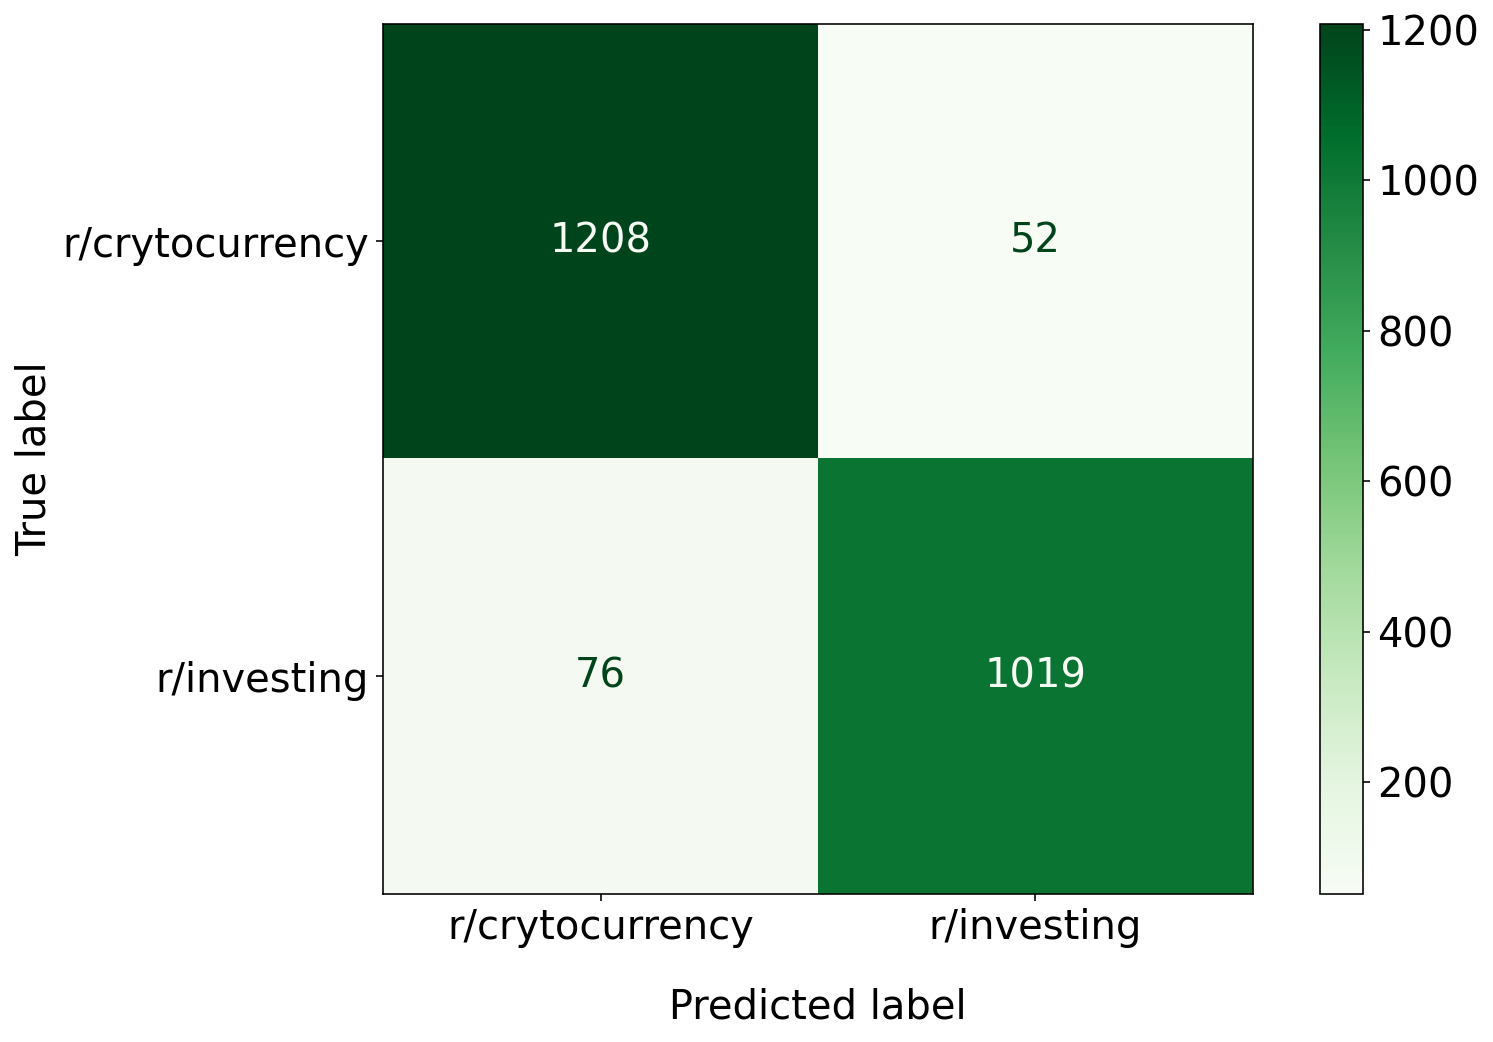

In [74]:
# check classification scores
scores(tvec_rf_gs)

The scores are not superior to the Logistic Regression from the perspective of accuracy, sensitivity and specificity. What's worth noting is that the training score is also 100%, just like the Gradient Boost! This could be a sign of overfitting given the variance with the test scores.\
This could be the strength of Random Forest, given that the model learns from its mistake through the trees.\
Furthermore, Random Forest is not a model with good interpretability.\
No heartache in not testing out this model in the earlier stages save for experimentation here.

### Testing with SVM Classifier


In [75]:
# setting up the pipeline
tvec_svc_pipeline = Pipeline([('tvec', TfidfVectorizer(max_features=3000, ngram_range=(1,4))),
                            ('svc', SVC())])

In [76]:
# defining the parameters
svc_params = [
    {
        'svc__C': [0.1, 1, 10, 100],
    }]

In [77]:
# instantiate gridsearchcv
tvec_svc_gs = GridSearchCV(tvec_svc_pipeline, param_grid=svc_params, cv=5, verbose=1, n_jobs=-1)

In [78]:
# fit the model
tvec_svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_features=3000,
                                                        ngram_range=(1, 4))),
                                       ('svc', SVC())]),
             n_jobs=-1, param_grid=[{'svc__C': [0.1, 1, 10, 100]}], verbose=1)

In [79]:
# check out the best params
tvec_svc_gs.best_params_

{'svc__C': 1}

Model : TF-IDF Vectorizer + Support Vector Machine
Best CV score : 94.4%
Train score : 98.8%
Test score (accuracy) : 95.2%
Sensitivity (true positive rate) : 94.3%
Specificity (true negative rate) : 96.0%
Precision (positive predictive rate) : 95.4%
F1-score : 94.9%


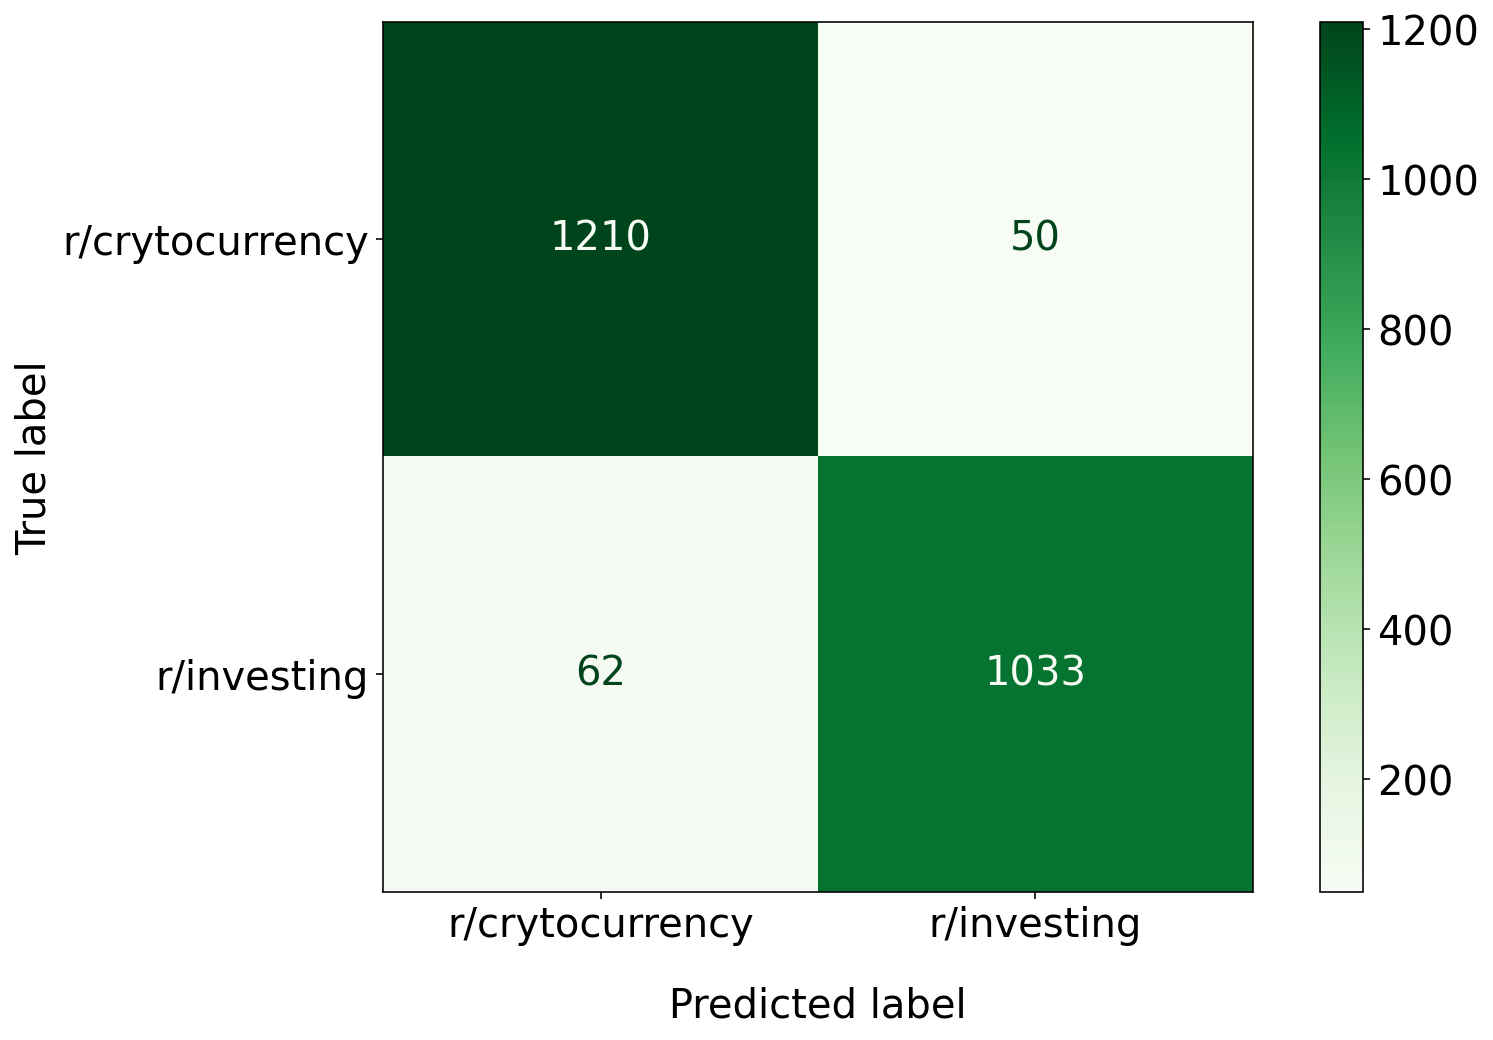

In [80]:
# check classification scores
scores(tvec_svc_gs)

Aha, finally a model that is better than Logistic Regression, even if slightly. There appears to be some signs of overfitting, given the variance between the train and test scores. Still, SVM is able to reduce the number of false positives (misclassified as r/investing) by 7 counts (50 for SVM vs. 57 for Logit), and also a lower number of false negatives (misclassified as r/cryptocurrency) by 2 counts (62 for SCVM vs. 64 for Logit).\
See summary statistics below:

| Model| Vectorizer| Best Cross Val| Train Accuracy| Test Accuracy| Sensitivity| Specificity| Precision| F1-Score|
|:-----|:---------:|:-------------:|:-------------:|:------------:|:----------:|:----------:|:--------:|:-------:|
|Logistic Regression   | TVEC | 94.1% |      95.9% |        94.9% |      94.2% |      95.5% |     94.8%|    94.5%|
|Support Vector Machine| TVEC | 94.4% |      98.8% |        95.2% |      94.3% |      96.0% |     95.4%|    94.9%|

Marginal improvements, but improvements nonetheless.
Out of curiosity, lets take a look if the misclassified posts are similar...

In [81]:
svm_pred = tvec_svc_gs.predict(X_test)
svm_pred.shape

(2355,)

Likewise, the misclass = 1 are for false negative (falsely classified as r/crytocurrency) and misclass = -1 are for false positives (falsely classified as r/investing)

In [82]:
svm_test_df = pd.DataFrame(zip(X_test, y_test, svm_pred), columns = ['text', 'actual', 'predictions'])
svm_test_df['misclass'] = svm_test_df['actual'] - svm_test_df['predictions']
svm_test_df.head(1)

,text,actual,predictions,misclass
0,divisibility cryptocurrency token divisibility break divisibility familiar dollar cent many currency use system usdaudetc one dollar one hundred cent really le one cent bank account dollar therefore divisible cent divide dollar one hundred cent cannot divide cent precision currency divided measured many decimal place support case dollar decimal place precision hereby known decimal cryptocurrencies revolutionising banking system exploring new frontier divisibility bitcoin example decimal place ie possible send receive little btc usd today price k usdbtc every person earth smallest unit bitcoin require btc price btc ever reach b btc thank hyperinflation smallest unit cost usd suddenly smallest unit may enough ethereum take next level course supporting decimal place precision quite hard fathom another way put say every person earth billion smallest unit ethereum require eth chemistry nut precision individual atom mg carbon p wrong number read comment whenever someone wrong internet so...,0,0,0


In [83]:
svm_test_df[svm_test_df['misclass']==1].head(5)

,text,actual,predictions,misclass
38,best friend asked guide invest crypto sure goodbad end recently got crypto month got good base term knowledge investing crypto particularly lower cap altcoins one time brought investing crypto two good friend month later one saying didnt want help succeed guiding sharing knowledge investing crypto eventually caved gonna guide start investing crypto knowledge term investing prior thus gonna investing larger market capped coin btc friend said wanted coin quote quote secure read lot money friend dont mix well together worried wont end good one day fall blame might even complain arent earning much road start getting greedy dont want come begging advice constantly certain gonna happen also keep asking much made much put crypto really bother dont want disclose earnings dont want think sort crypto god whatever average kid passionate investing crypto worked hard get knowledge dont want take advantage situation really want happen future make good money future altcoins gonna didnt tell keepi...,1,0,1
47,need advice possible good daynight everyone wasting lot money student wasting monthly almost usd last yr least since came college tho studying properly used say excuse fun lately watching lot video searching lot investment could give small advice whether something without getting scam really appreciate thank keep working hard,1,0,1
183,many people fell watermineioponzi tower finally collapsing week ago mom told crypto mining site guarantee daily return original investment catch tried explain company guarantee stable daily return fluctuating currency crypto course went one ear invested money anyways fast forward one week later waterminehttpswatermineio claiming hacked allowing user withdraw shocker still allow give money lol even took notice hacked front page site get little bit money drop good,1,0,1
211,lifetime deal take hope right subreddit family member offer garage buy k garage located middle block house streetside middle garage usually belong owner house opportunity buy one garage uncle uncle dad one got dad died uncle want get rid asap doesnt want deal stuff come buy price k garage sell k right located neighborhood there always someone want rent dad never trouble finding someone rent price maybe soon ask garage month sound good deal think still bit unsure there one old guy life owns lot garage he kind troublemaker couldnt buy garage family owns dad bit trouble tried blocking garage door etc simple bullying ask difficult deal legally however one right come rule etc cant u much harm question good deal getting really appreciate opinion deal good think,1,0,1
217,k ready portfolio development debtfree ive almost got k saved highyield saving account dont sitting collecting month wanted ask guy advice couple thing main question fundrise thing btw fidelity account ready go invest today yes much fundrise worth got email via mint thanks much hope everyone safe loved one well,1,0,1


Interestingly, the first 5 (false negative) posts misclassified as r/crytocurrency by the SVM are identical to the Logit, i.e. indexes = 38, 47, 183, 211, 217

In [84]:
svm_test_df[svm_test_df['misclass']==-1].head(5)

,text,actual,predictions,misclass
27,today german government auction bitcoins darknet drug dealer worth million eur interesting case germany today ministry justice one germany state nrw auction bitcoins guy got caught selling drug internet government got access bitcoins wondered could legal counsel came conclusion treated item gained criminal activity hence auctioned sold public state keep money auction lead big hype germany auction usually lead discount whatever sold thought guy might find interesting article german background info httpswwwsueddeutschedewirtschaftbitcoinkryptowaehrungauktionnrwjustizministeriumamp need translation deeplcom provides best english ltgt german translation service,0,1,-1
71,myopic loss aversion panic sell sell early lock gain could gained far shown patience httpswwwbehavioraleconomicscomresourcesminiencyclopediaofbemyopiclossaversion myopic loss aversion occurs investor take view investment strongly focused short term leading react negatively recent loss may expense longterm benefit thaler et al phenomenon influenced narrow framing result investor considering specific investment eg individual stock trade without taking account bigger picture eg portfolio whole sequence trade time kahneman amp lovallo largescale field experiment shown individual receive information investment performance frequently tend underinvest riskier asset losing potential better longterm gain larson et al httpwwwbehavioraleconomicscommyopiclossaversionabehavioralanswertotheequitypremiumpuzzle experiment come partnering technology trading firm normann used beta test trading platform see access price information affected professional investor willingness take risk ultimate profit ...,0,1,-1
135,year old learns daytrade crypto httpswwwyoutubecomwatchvlnifdfxvmyhttpswwwyoutubecomwatchvlnifdfxvmy hey guy name hasan yearold guy uk ive interested investingtrading around year investing crypto stock longterm roughly average return across portfolio last year however never properly ventured day tradingswing tradingscalping began get around year ago using macd rsi ema crap realised tbh doesnt really work ive revamped way traded based primarily price action identifying key level chart going ive decided create youtube series every week youll get see progression learning market work different book yt channel etc eventually applying understanding hopefully make profit short term trading begin lose well mean learning done ill take break trading real money go back paper practice refining error made past hope guy enjoy series ill post well keep updated,0,1,-1
162,geist token geist protocol decrease every day aped geist protocol fantom chain looked interesting every day geist reward tanking anybody explain dynamic text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text tex...,0,1,-1
185,kakadu casino game right finishing kakadu casino login trigger generous welcome bonus available across initial four deposit maximum bonus amount obtain minimum amount must deposit modest get better idea kakadu casino welcome bonus st deposit bonus match free spin nd deposit bonus match rd deposit bonus match th deposit bonus match free spin getting bonus keep mind kakadu casino free spin activ

3 out of first 5 (false positive) posts misclassified as r/investing by the SVM are identical to the Logit, i.e. indexes = 27, 71, 235.\
Lets break it down into a table form and take a look the individual post to discern any interesting pattern or insights of model behaviour.

| Post Indexes | Misclassified by Logit | Misclassified by SVM |
|:------------:|:----------------------:|:--------------------:|
|       27     |           yes          |         yes          |
|       71     |           yes          |         yes          |
|    **127**   |           yes          |       **no**         |
|      135     |           yes          |         yes          |
|    **162**   |         **no**         |         yes          |
|    **171**   |           yes          |       **no**         |
|      185     |           yes          |         yes          |


In [85]:
svm_test_df.loc[[127,162,171],:]

,text,actual,predictions,misclass
127,big usd inflow coming somewhere buy btc anyone evidence subject suggests recent runup doesnt retail buying probably explanation one guess money coming investment bank central bank hedge fund maybe anticipation strong news u regulatory environment time year always hard past ive seen company glassnode come public research showing money flow certain direction supporting strong hypothesis wondering anyone happens similar theory evidence back cheer,0,0,0
162,geist token geist protocol decrease every day aped geist protocol fantom chain looked interesting every day geist reward tanking anybody explain dynamic text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text tex...,0,1,-1
171,u miner hosting market saturation lady gentleman u market saturation real electrical cost hosting rate pushing higher higher cent new cent mining high scale cent new five cent hosting cent new expensive pay still making money happy hosting thing get attacked people comment say compass offer interesting compass care upcharging electrical hosters get electrical cent charge rate make buy miner k markup make money per miner five year stretch cent markup example one pull watt hrsday kw x day x day month month profit hosting one cent markup x month year year x year projected life brand new compass get power cent charge cent view bit high right instead smart enough charge cent cent require buy miner k margin give money right away capital handoff expansion make think rate awesome although month wait get miner hosted month long response miner go one month profit electrical pay smaller facility cent year better going cent power hosting avoid long time lengthy repair two month year suggests c...,0,0,0


In [86]:
# seek out the probability of 'test' in the Logit predictor
crypto_coef[crypto_coef['feature'].str.contains('text', regex=False)==True]

,feature,coef,odds,1-prob,prob
2647,text,-0.414392,0.660742,39.785936,60.214064
579,context,0.189549,1.208704,54.724580,45.275420


Post #162 contains a wall of 'text'... literally.\
Based on the Logit coefficient, 'text' has a 60% chance to be associated with the r/cryptocurrency subreddit. Unfortunately for the SVM, we are not able to investigate under the hood how the classification is being carried out that it was able to correctly classify the 2 posts that Logit was not able to.

### Testing with K-Nearest Neighbors Classifier

In [87]:
# setting up the pipeline
tvec_knn_pipeline = Pipeline([('tvec', TfidfVectorizer(max_features=3000, ngram_range=(1,4))),
                            ('knn', KNeighborsClassifier())])

In [88]:
# defining the parameters
knn_params = [
    {
        'knn__n_neighbors': [100, 110, 120, 130, 140],
    }]

In [89]:
# instantiate gridsearchcv
tvec_knn_gs = GridSearchCV(tvec_knn_pipeline, param_grid=knn_params, cv=5, verbose=1, n_jobs=-1)

In [90]:
# fit the model
tvec_knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_features=3000,
                                                        ngram_range=(1, 4))),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [100, 110, 120, 130, 140]}],
             verbose=1)

In [91]:
# check out the best params
tvec_knn_gs.best_params_

{'knn__n_neighbors': 130}

Model : TF-IDF Vectorizer + K-Nearest Neighbors
Best CV score : 92.7%
Train score : 92.7%
Test score (accuracy) : 92.9%
Sensitivity (true positive rate) : 90.5%
Specificity (true negative rate) : 95.0%
Precision (positive predictive rate) : 94.0%
F1-score : 92.2%


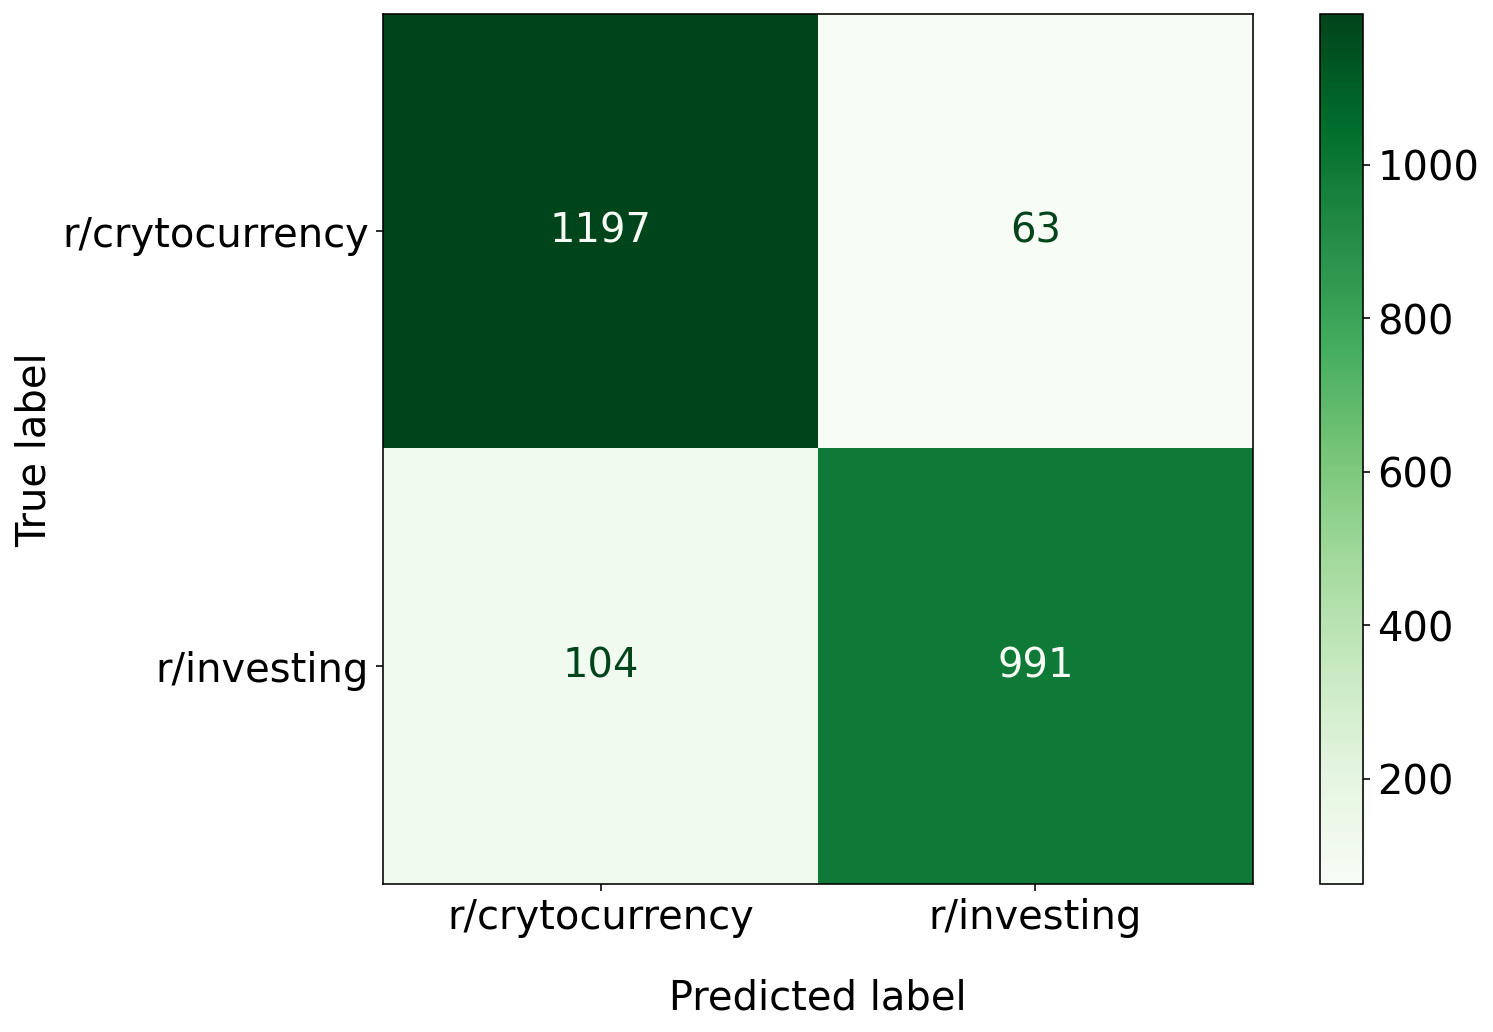

In [92]:
# check classification scores
scores(tvec_knn_gs)

Similar to the earlier experimental models, the KNN scores are not superior to the Logistic Regression from the perspective of accuracy, sensitivity and specificity. What's worth noting is that KNN has a significantly lower sensitivity, i.e. falsely classifying r/investing posts as r/cryptocurrency.\
Anyhow, KNN is not a model with good interpretability.\
No heartache in not testing out this model in the earlier stages save for experimentation here.

### Summary metrics

| Model| Vectorizer| Best Cross Val| Train Accuracy| Test Accuracy| Sensitivity| Specificity| Precision| F1-Score|
|:-----|:---------:|:-------------:|:-------------:|:------------:|:----------:|:----------:|:--------:|:-------:|
|Naive Bayes Classifier| CVEC | 92.2% |      92.7% |        92.2% |      88.5% |      95.4% |     94.4%|    91.3%|
|Naive Bayes Classifier| TVEC | 92.3% |      93.3% |        92.6% |      90.0% |      94.9% |     93.9%|    91.9%|
|Logistic Regression   | CVEC | 93.6% |      95.3% |        94.2% |   **94.3%**|      94.0% |     93.2%|    93.8%|
|**Logistic Regression (selected prior)**| **TVEC** | 94.1% |    95.9% |  94.9% |      94.2% |      95.5% |     94.8%|    94.5%|
|Gradient Boost Classifier| TVEC|  93.4% |**100.0%**|        93.7% |      93.4% |      93.9% |     93.0%|    93.2%|
|Random Forest Classifier| TVEC|   94.2% |**100.0%**|        94.6% |      93.1% |      95.9% |     95.1%|    94.1%|
|Support Vector Machine Classifier| TVEC| **94.4%**|  98.8% |**95.2%**|**94.3%**|   **96.0%**|  **95.4%**|**94.9%**|
|K-Nearest Neighbors Classifier| TVEC|  92.6% |    92.6% | 92.7% |       90.1% |      94.8% |     93.8%|    91.9%|